In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [5]:
umi = sc.read_h5ad("/mnt/ccle_umi.h5ad")
umi.var.index = umi.var['Unnamed: 0']
umi_process = sc.read_h5ad('/mnt/ccle_umi_process.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Characterize CNA structure within each cancer type for each cell line

In [248]:
cancer_type_cluster = []
for cancer_type in umi_process.obs['cancer_type'].unique().dropna():

    subtype = umi_process[umi_process.obs['cancer_type'] == cancer_type]
    cna_list = []
    for p in subtype.obs.CCLE_ID.unique():
        cna = pd.read_csv(f"/mnt/{p}_cna.csv")
        cna.index = cna['arm']
        cna=cna.drop(columns = ['arm']).T
        cna['patient'] = p
        cna_list.append(cna)
    skin_cna = pd.concat(cna_list)
    cna_cluster = []

    for p in skin_cna.patient.unique():

        process = skin_cna[skin_cna['patient'] == p].drop(columns = 'patient').T
        process['arm_number'] = [str.replace(p,'p','') for p in process.index]
        process['arm_number'] = [str.replace(p,'q','') for p in process['arm_number']]
        process['arm_number'] = [int(f) for f in process['arm_number']]

        clustering = AgglomerativeClustering(n_clusters = 2).fit(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T)

        score = silhouette_score(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T, 
                                 clustering.labels_)

        #Counter(clustering.labels_)
        cna_cluster.append({'patient':p, 'cancer_type':cancer_type, 'silhouette_score':score ,
                            'size_0': Counter(clustering.labels_)[0], 'size_1' :Counter(clustering.labels_)[1]  })

    cna_cluster = pd.DataFrame(cna_cluster)
    #cna_cluster = cna_cluster[cna_cluster['size_1']>10]
    cancer_type_cluster.append(cna_cluster.sort_values(by = "silhouette_score", ascending = False))

In [250]:
cancer_type_cluster_df= pd.concat(cancer_type_cluster)

In [286]:
cancer_type_cluster_df['subtype'] = ((cancer_type_cluster_df['size_1']>10) & 
                                     (cancer_type_cluster_df['size_0']>10) & 
                                     (cancer_type_cluster_df['silhouette_score']>0.2))
cancer_type_cluster_df['subtype_less'] = ((cancer_type_cluster_df['size_1']>10) & 
                                     (cancer_type_cluster_df['size_0']>10) & 
                                     (cancer_type_cluster_df['silhouette_score']>0.1))

In [290]:
count = pd.concat([cancer_type_cluster_df.groupby(by = ['cancer_type']).sum()[['subtype']],
                   cancer_type_cluster_df.groupby(by = ['cancer_type']).sum()[['subtype_less']],
                   cancer_type_cluster_df.groupby(by = ['cancer_type']).count()[['patient']],
                  ], 
                  axis = 1).reset_index().sort_values(by = "subtype_less", ascending = False)

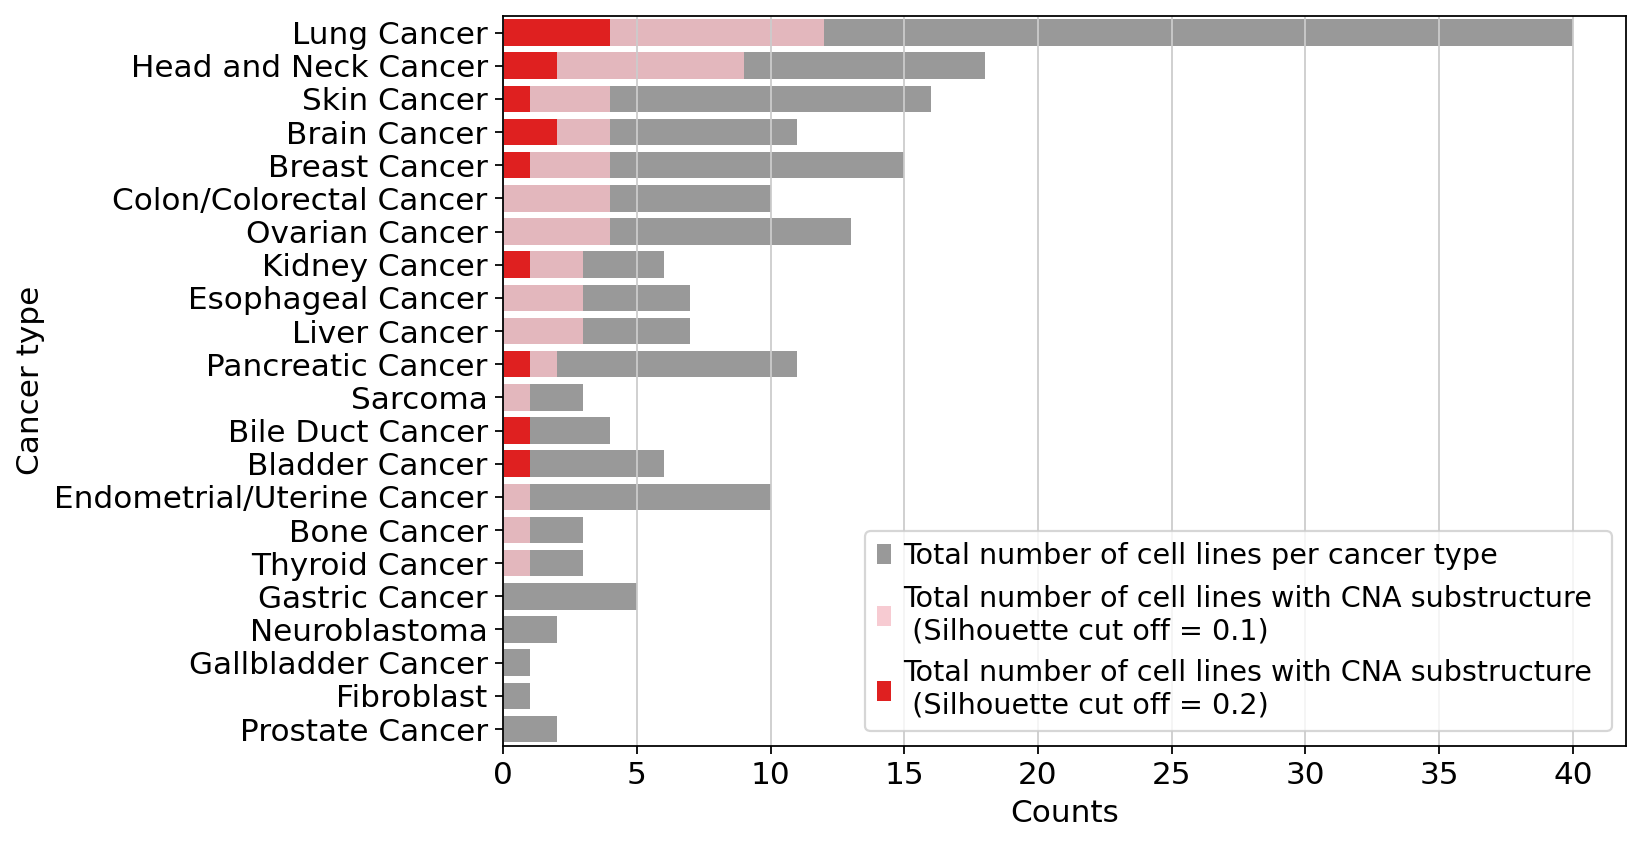

In [294]:
plt.subplots(figsize = (9,6))
sns.barplot(data = count, y = "cancer_type", x = "patient", color = "grey", label = "Total number of cell lines per cancer type", alpha = 0.8)
sns.barplot(data = count, y = "cancer_type", x = "subtype_less", color = "lightpink", label = "Total number of cell lines with CNA substructure \n (Silhouette cut off = 0.1)", alpha = 0.8)
sns.barplot(data = count, y = "cancer_type", x = "subtype", color = "red", label = "Total number of cell lines with CNA substructure \n (Silhouette cut off = 0.2)")
plt.xlabel("Counts")
plt.ylabel("Cancer type")
plt.legend()
plt.show()

### Cell line specific heatmap and clustering on CNA

In [318]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [333]:
def cluster_performance(p):

    cna = pd.read_csv(f"/mnt/{p}_cna.csv")
    cna.index = cna['arm']
    cna=cna.drop(columns = ['arm']).T
    cna['patient'] = p

    process = cna.drop(columns = ['patient']).T
    process['arm_number'] = [str.replace(p,'p','') for p in process.index]
    process['arm_number'] = [str.replace(p,'q','') for p in process['arm_number']]
    process['arm_number'] = [int(f) for f in process['arm_number']]

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold = 0, n_clusters = None)
    model = model.fit(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T)
    plt.subplots(figsize= (10,5))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Hierarchical clustering of copy number alteration \n Number of points in node (or index of point if no parenthesis)")
    plt.show()

    clustering = AgglomerativeClustering(n_clusters = 2).fit(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T)
    heatmap = process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T
    heatmap['cluster'] = clustering.labels_
    lut1 = dict( zip([0,1], [ 'green','purple']))
    row_colors1 = heatmap.cluster.map(lut1)

    score = silhouette_score(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T, 
                             clustering.labels_)

    sns.clustermap(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T, 
                   col_cluster =  False,
                   row_cluster = True,
                   yticklabels= False,
                   metric = "euclidean", 
                   row_colors = row_colors1,
                   xticklabels = process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T.columns,
                   cmap = "vlag", figsize=(20,6), vmax= 1,vmin=-1
                  )
    plt.show()

    silhouette_avg = silhouette_score(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T, clustering.labels_)
    sample_silhouette_values = silhouette_samples(process.sort_values(by = 'arm_number').drop(columns = ['arm_number']).T, 
                                                  clustering.labels_)
    cluster_labels = clustering.labels_
    n_clusters = 2

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    ax1.set_xlim([-0.1, 1])

    y_lower = 10
    for i, color in zip(range(2), ['green','purple'] ) :
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for \n copy number alteration hierarchical clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

In [320]:
cancer_type_cluster_df[cancer_type_cluster_df['subtype'] == True]['patient']

26                      NCIH1568_LUNG
38                      NCIH2444_LUNG
33                          ABC1_LUNG
35                      NCIH1435_LUNG
1                        COLO741_SKIN
3     CCFSTTG1_CENTRAL_NERVOUS_SYSTEM
5       SW1088_CENTRAL_NERVOUS_SYSTEM
14                    MDAMB436_BREAST
2                 UMUC1_URINARY_TRACT
9     SNU46_UPPER_AERODIGESTIVE_TRACT
1     BICR6_UPPER_AERODIGESTIVE_TRACT
2                        OSRC2_KIDNEY
3                 HUH28_BILIARY_TRACT
8                      PK45H_PANCREAS
Name: patient, dtype: object

In [419]:
cancer_type_cluster_df[cancer_type_cluster_df['patient'] == "HUH28_BILIARY_TRACT"]

patient       cancer_type  silhouette_score  size_0  size_1  \
3  HUH28_BILIARY_TRACT  Bile Duct Cancer          0.221441      56      83   

   subtype  subtype_less  
3     True          True

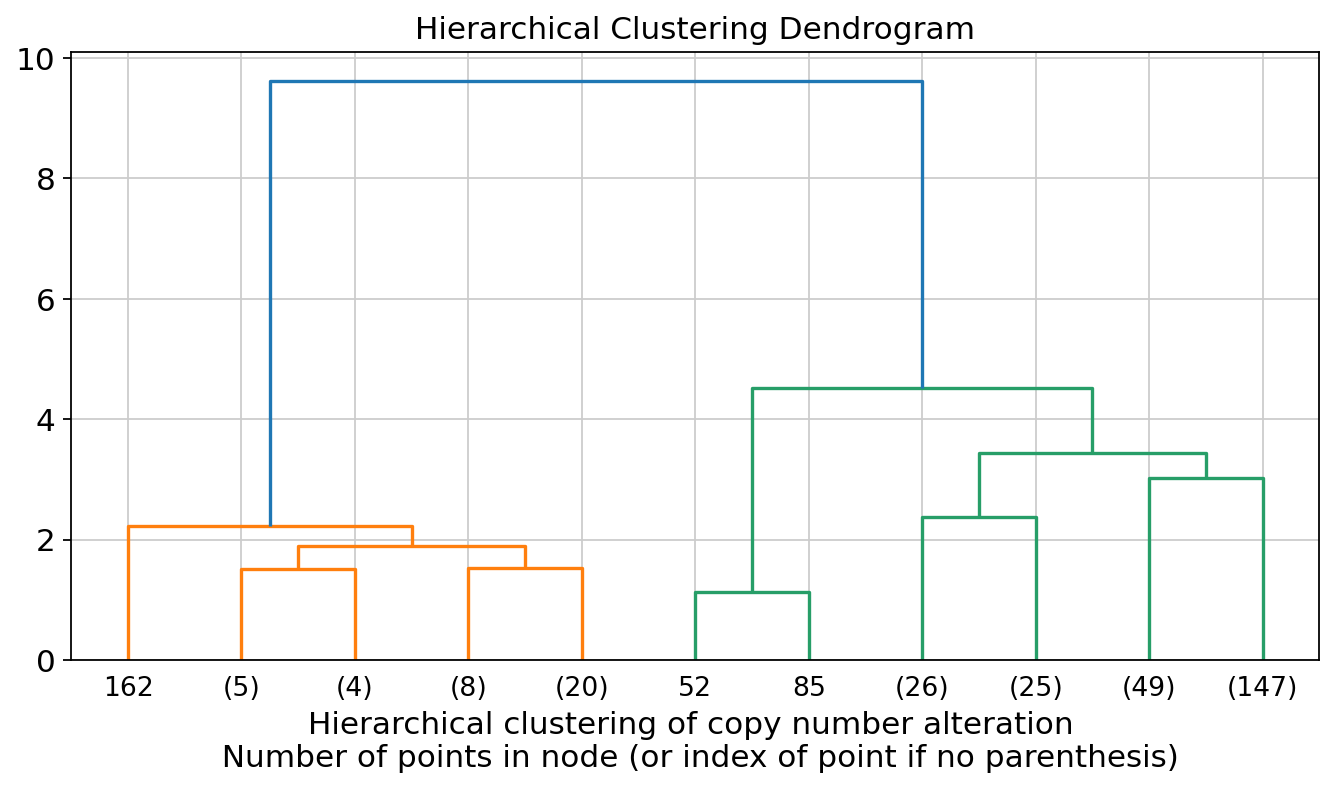

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


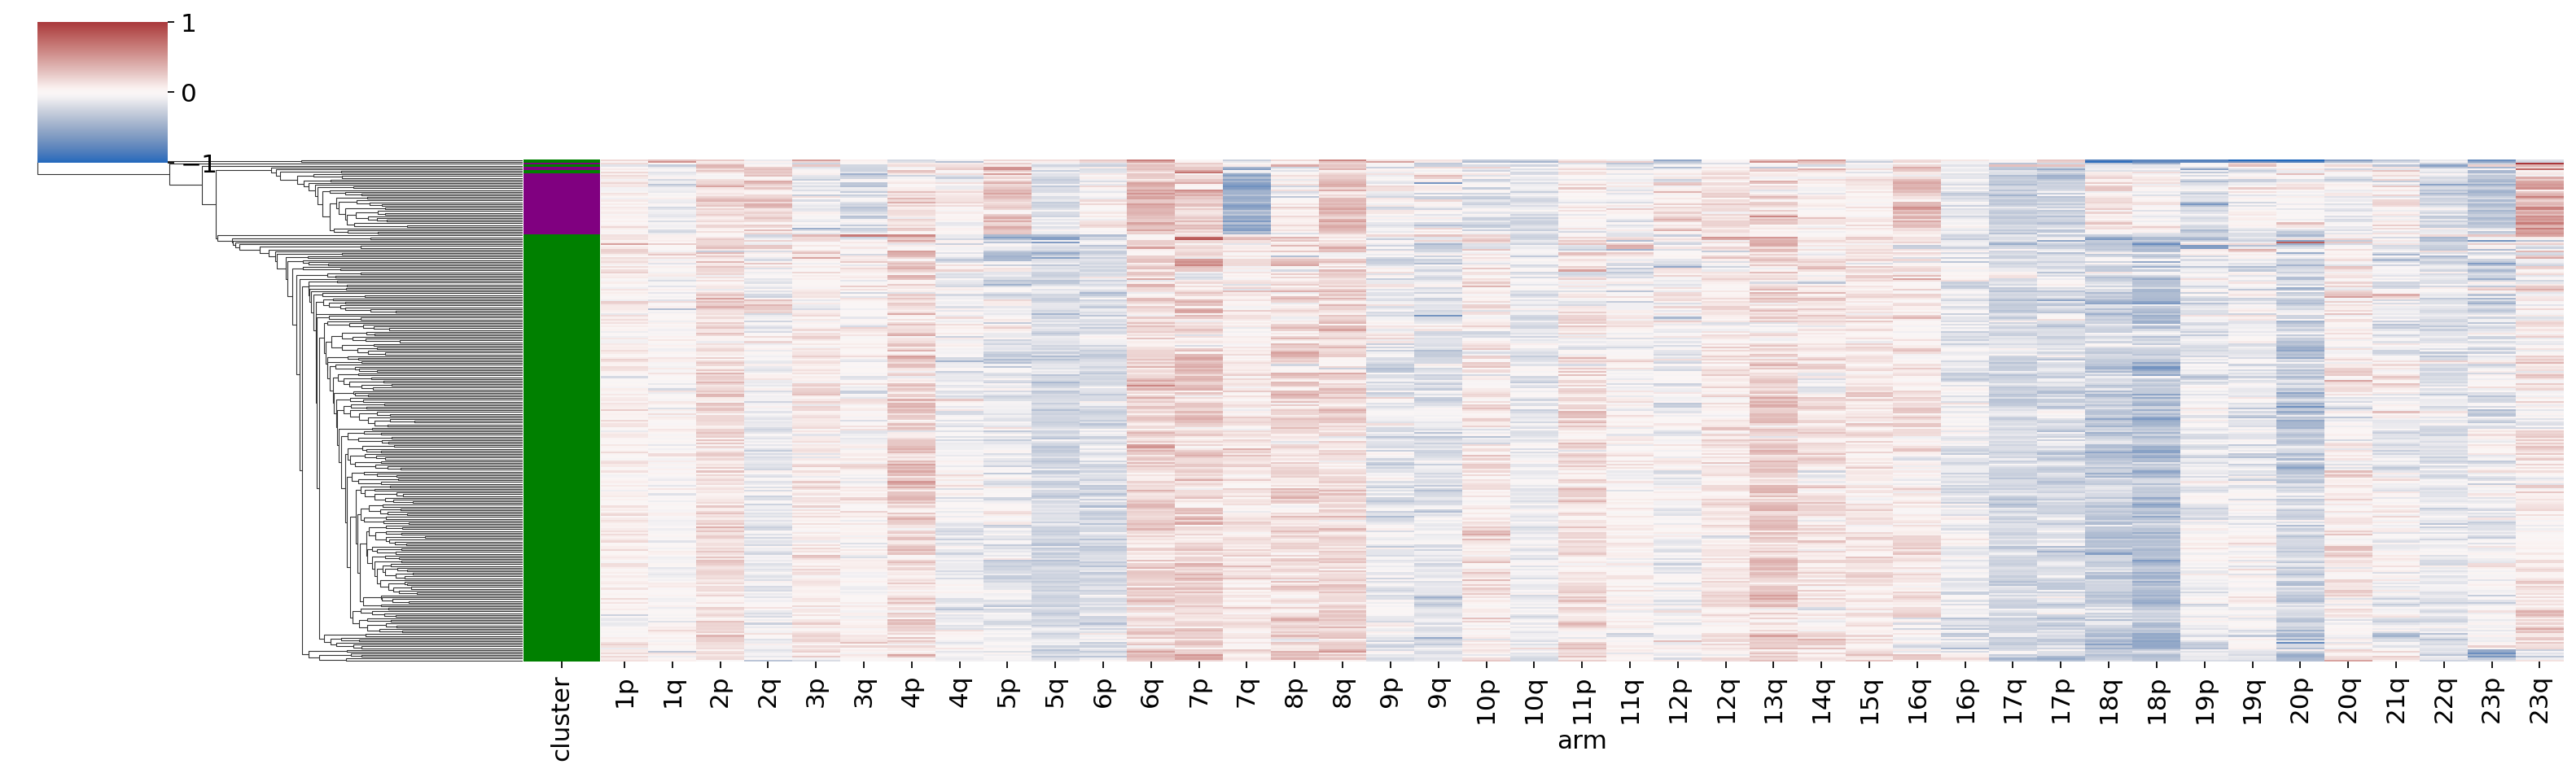

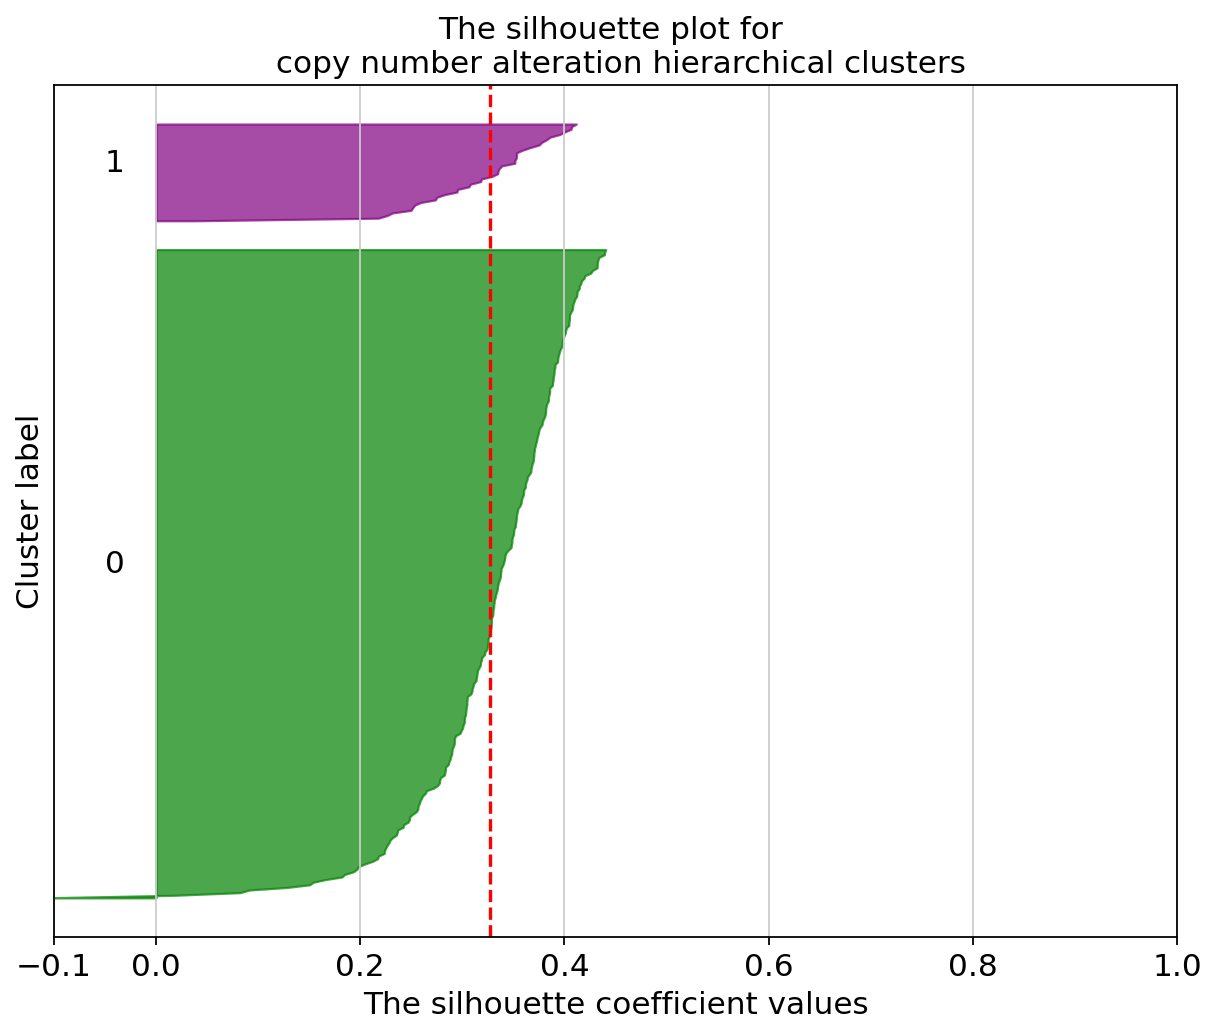

In [327]:
cluster_performance(p = 'NCIH1568_LUNG' )

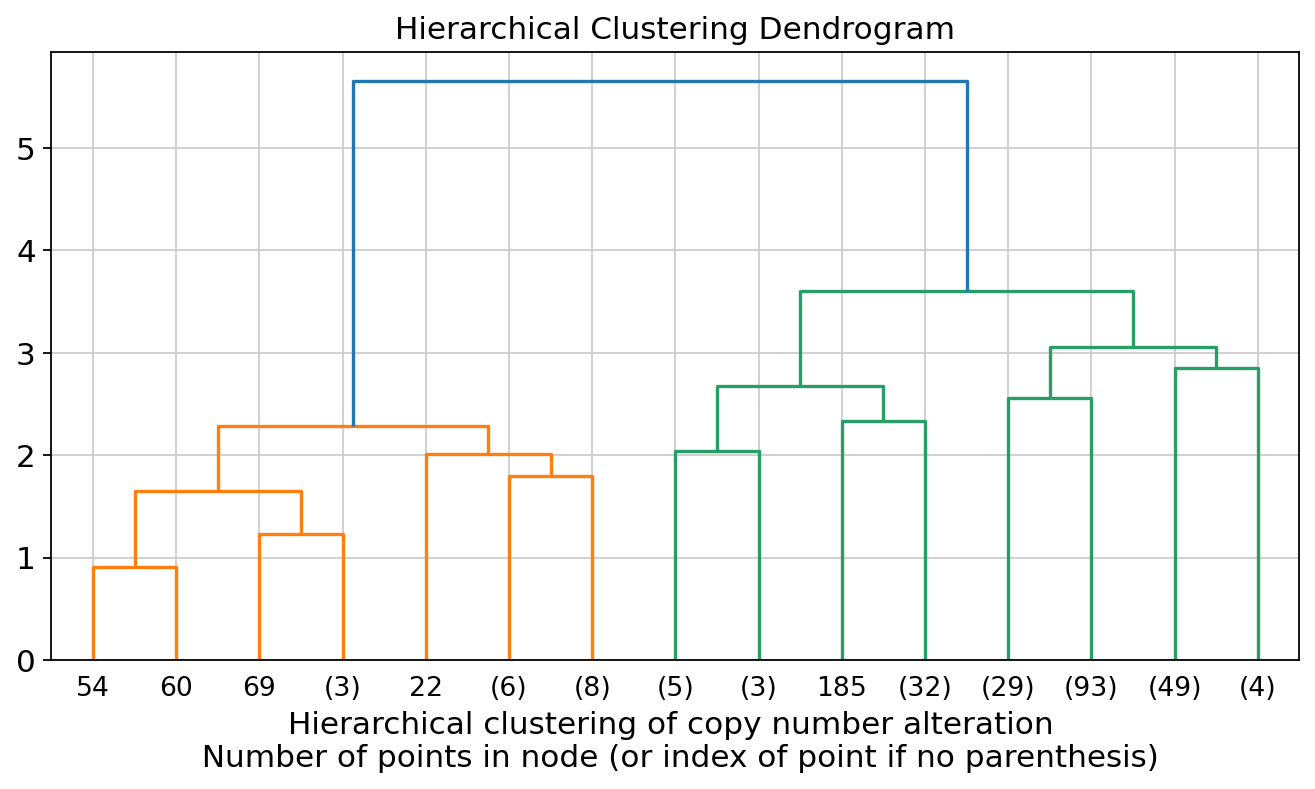

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

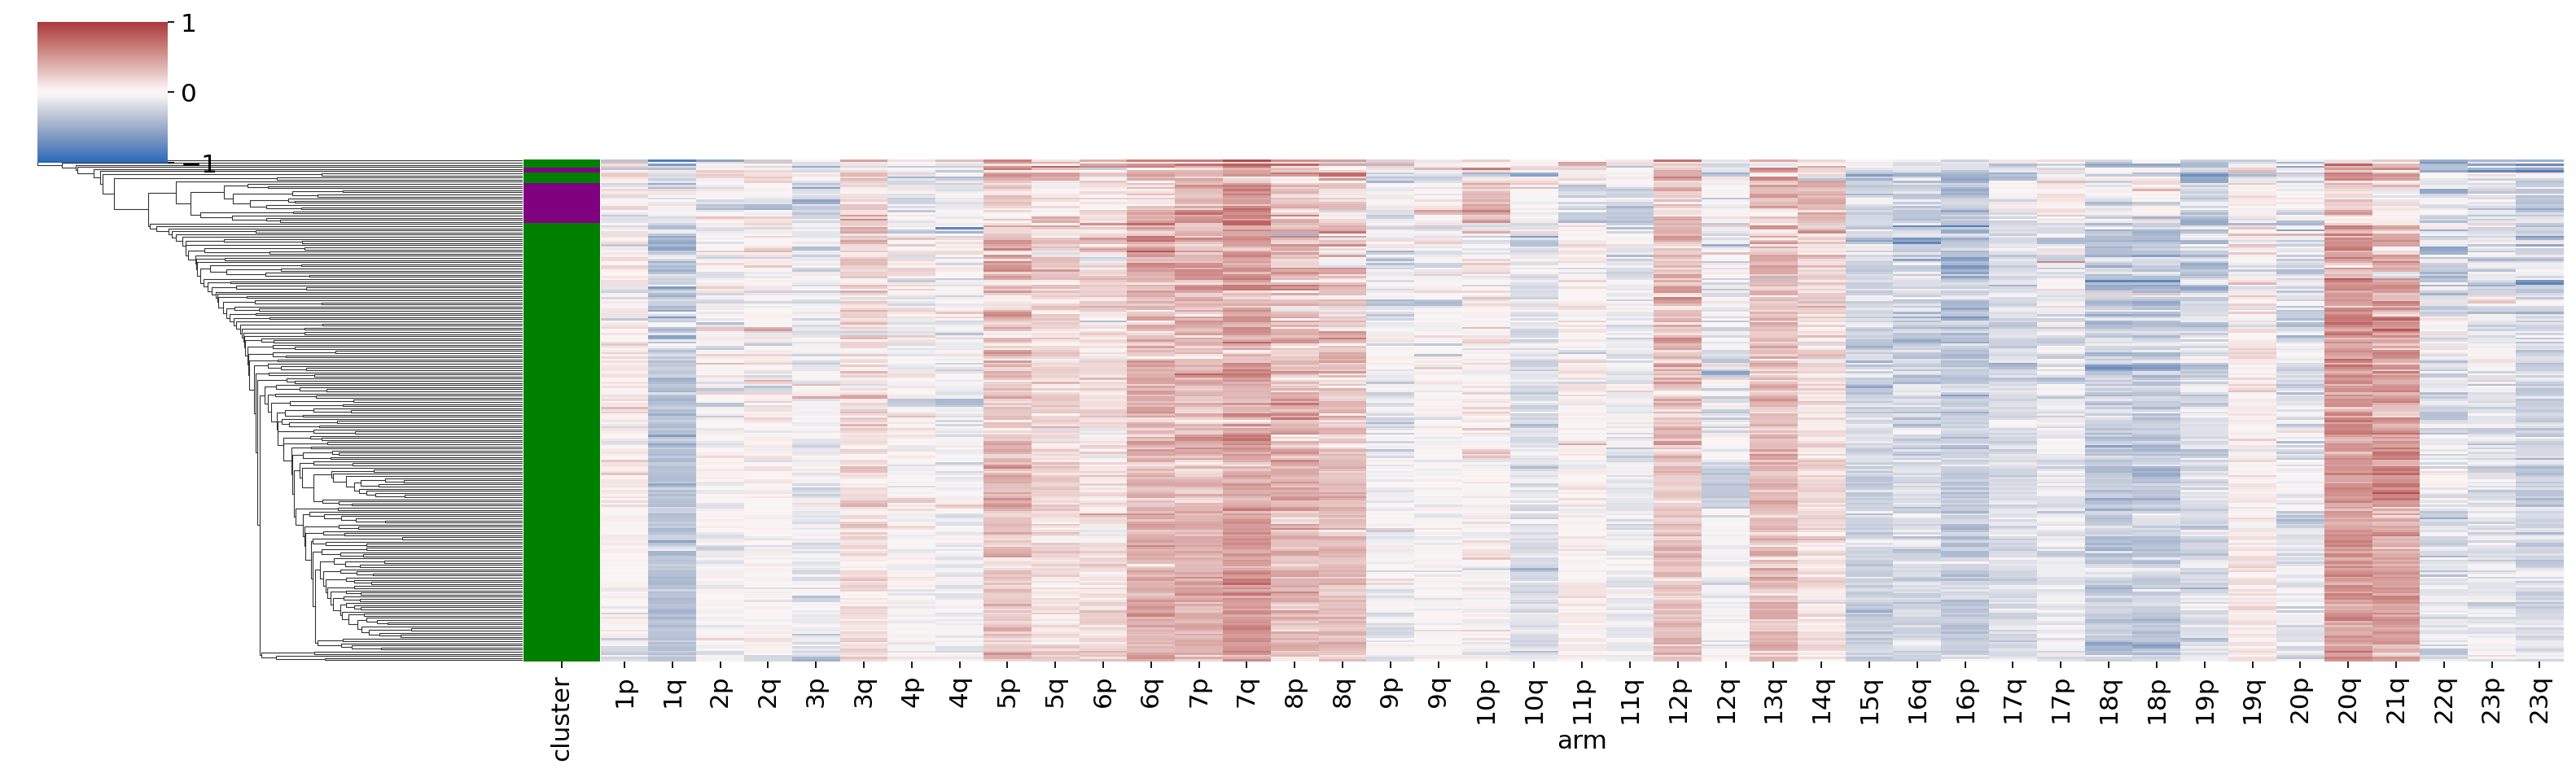

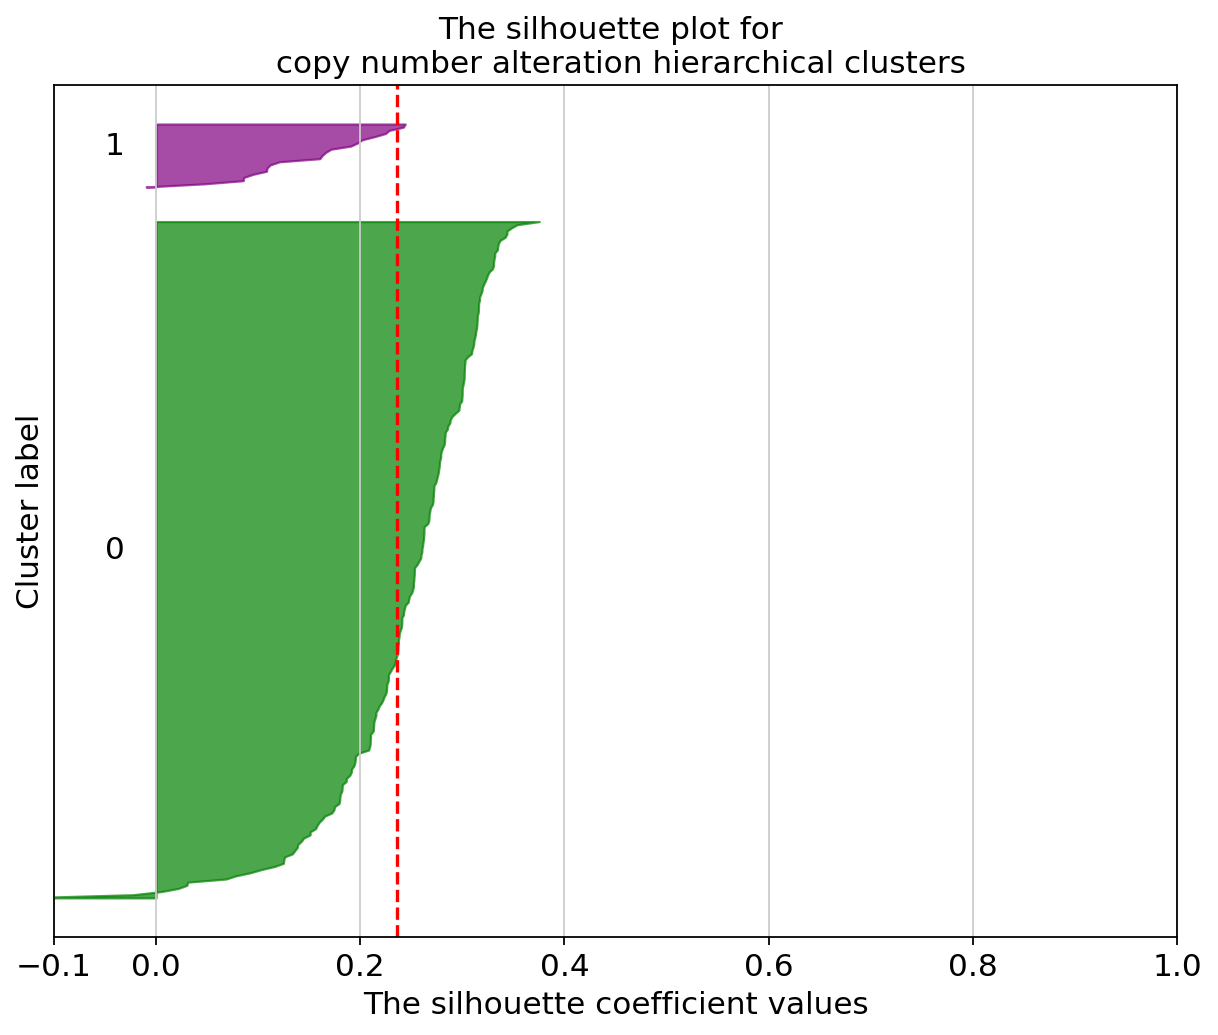

In [328]:
cluster_performance(p = 'NCIH2444_LUNG' ) ##no

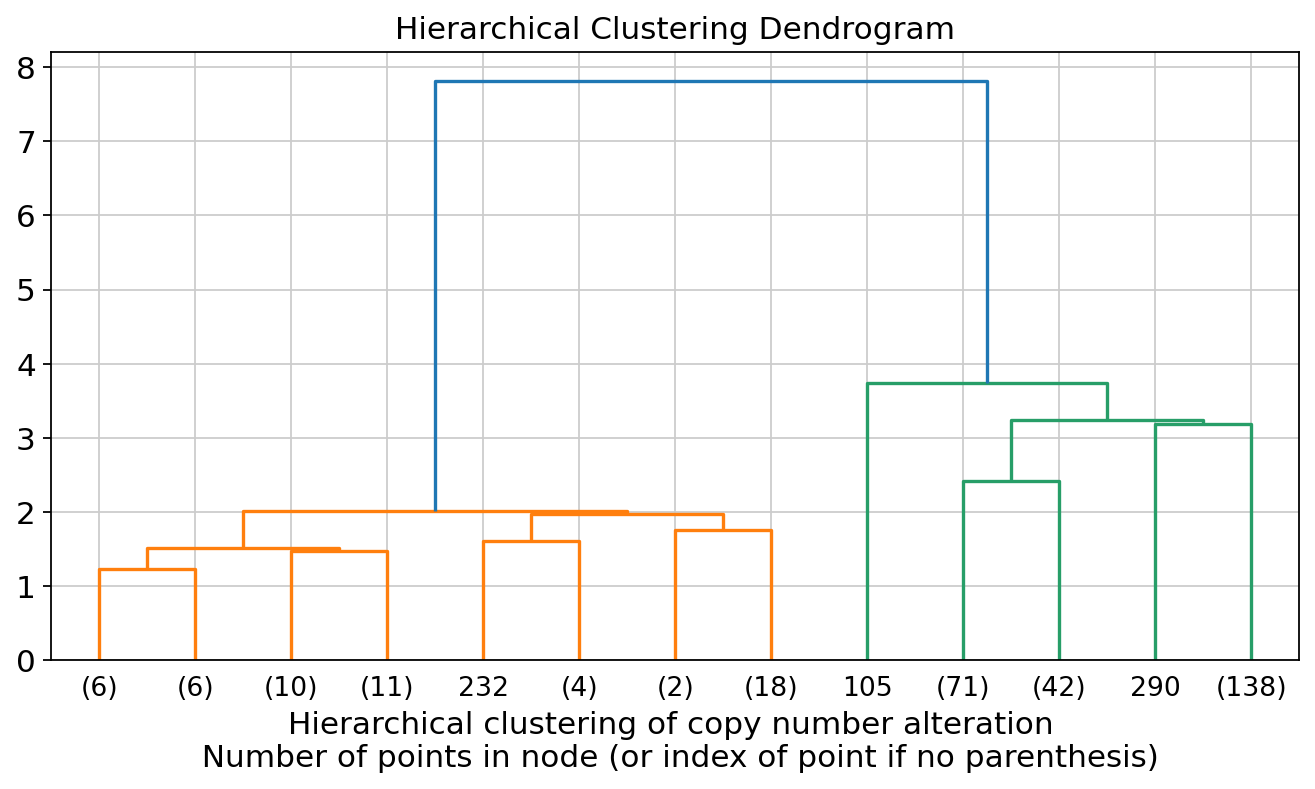

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


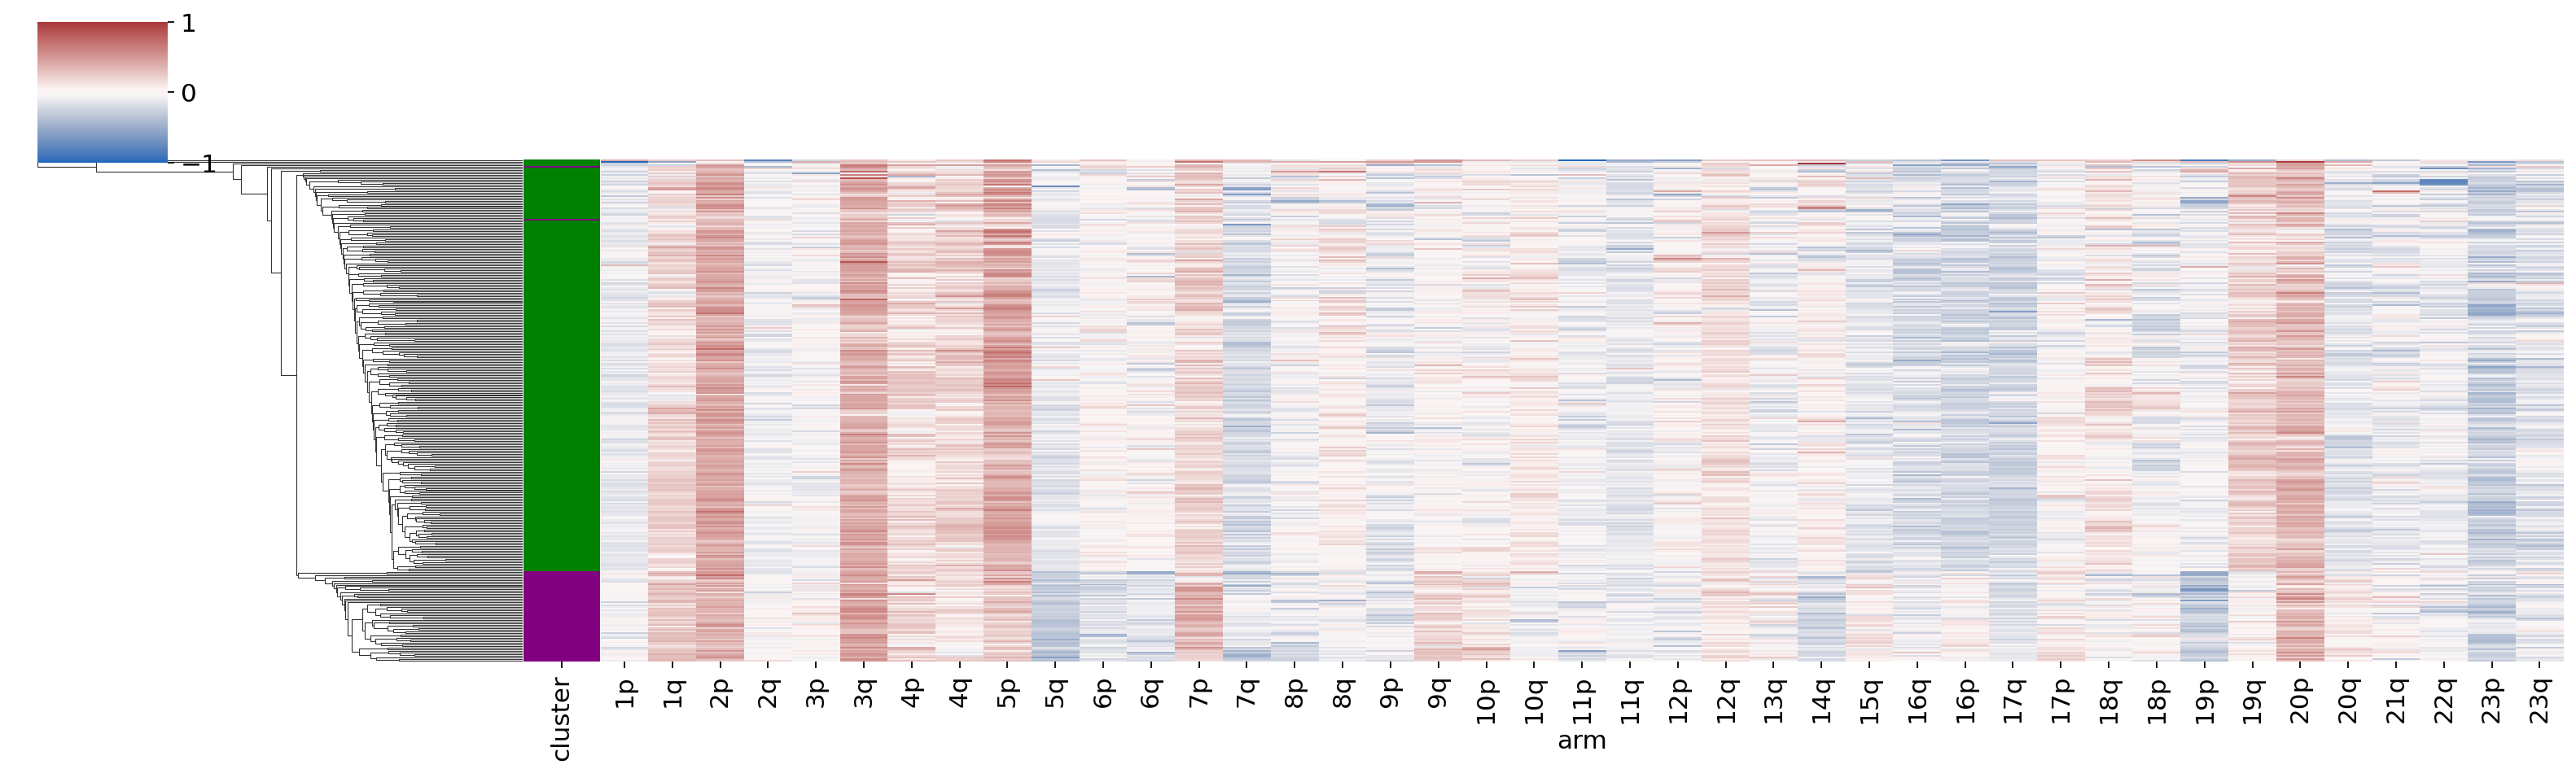

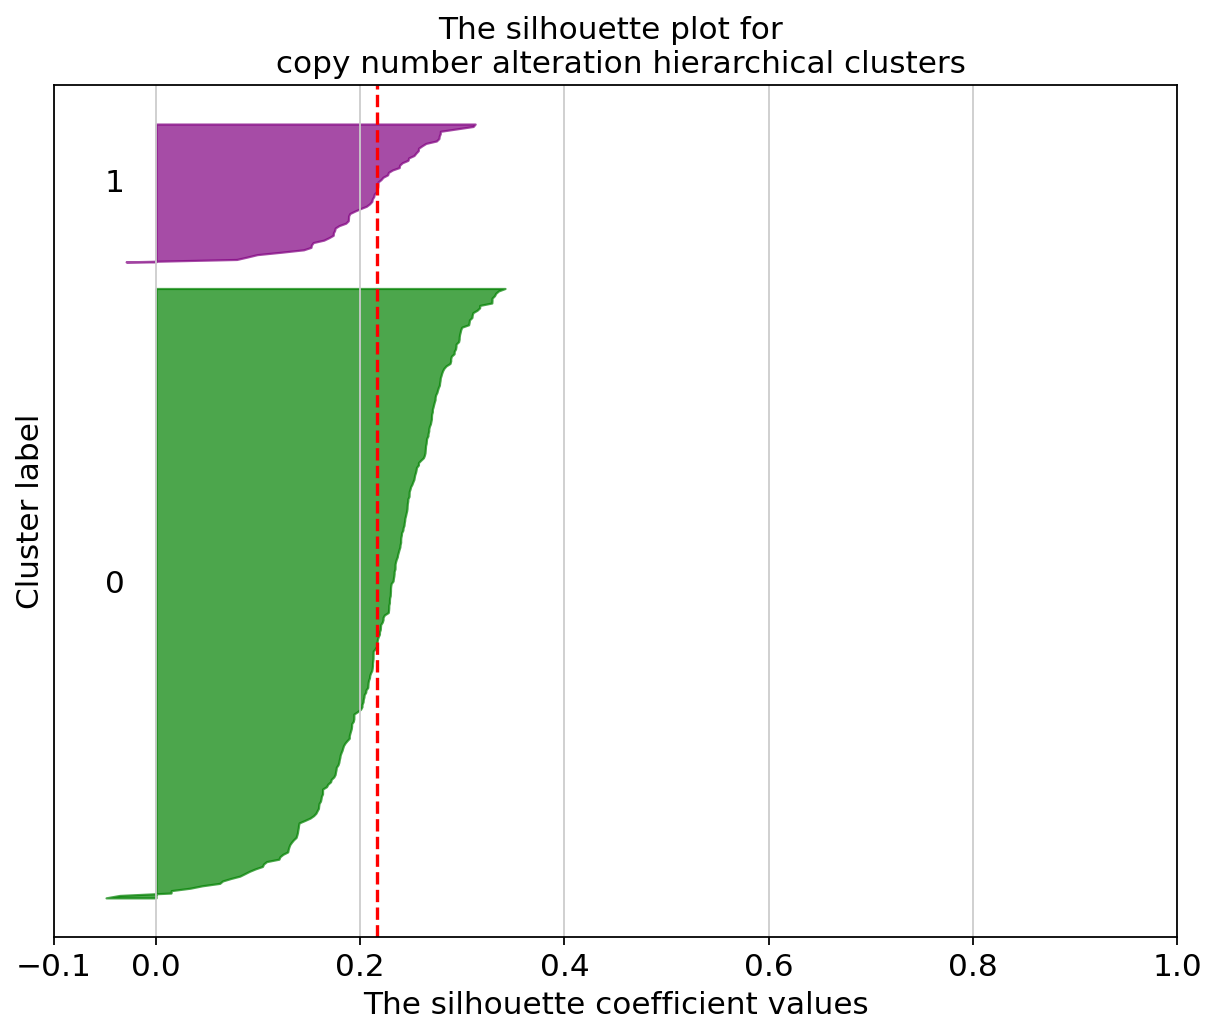

In [334]:
cluster_performance(p = 'ABC1_LUNG' )

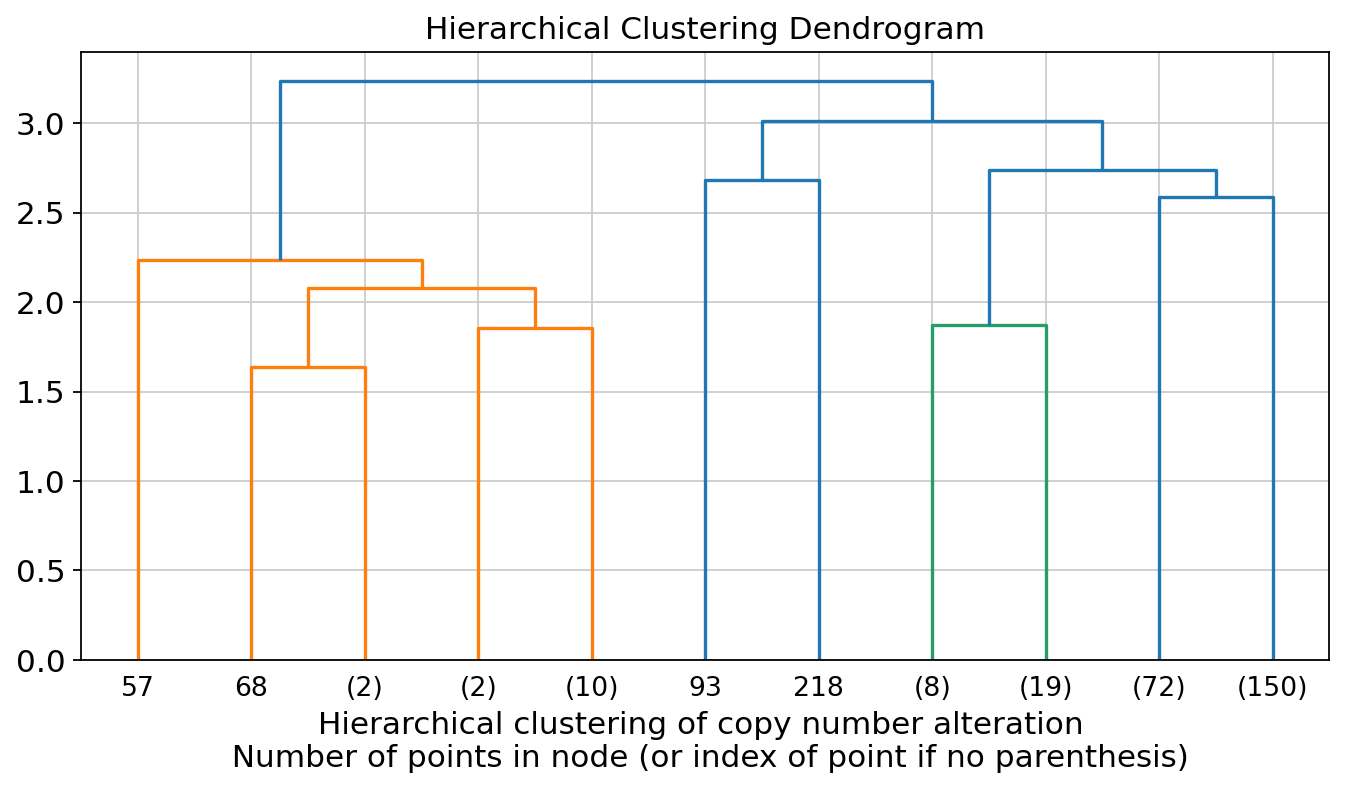

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


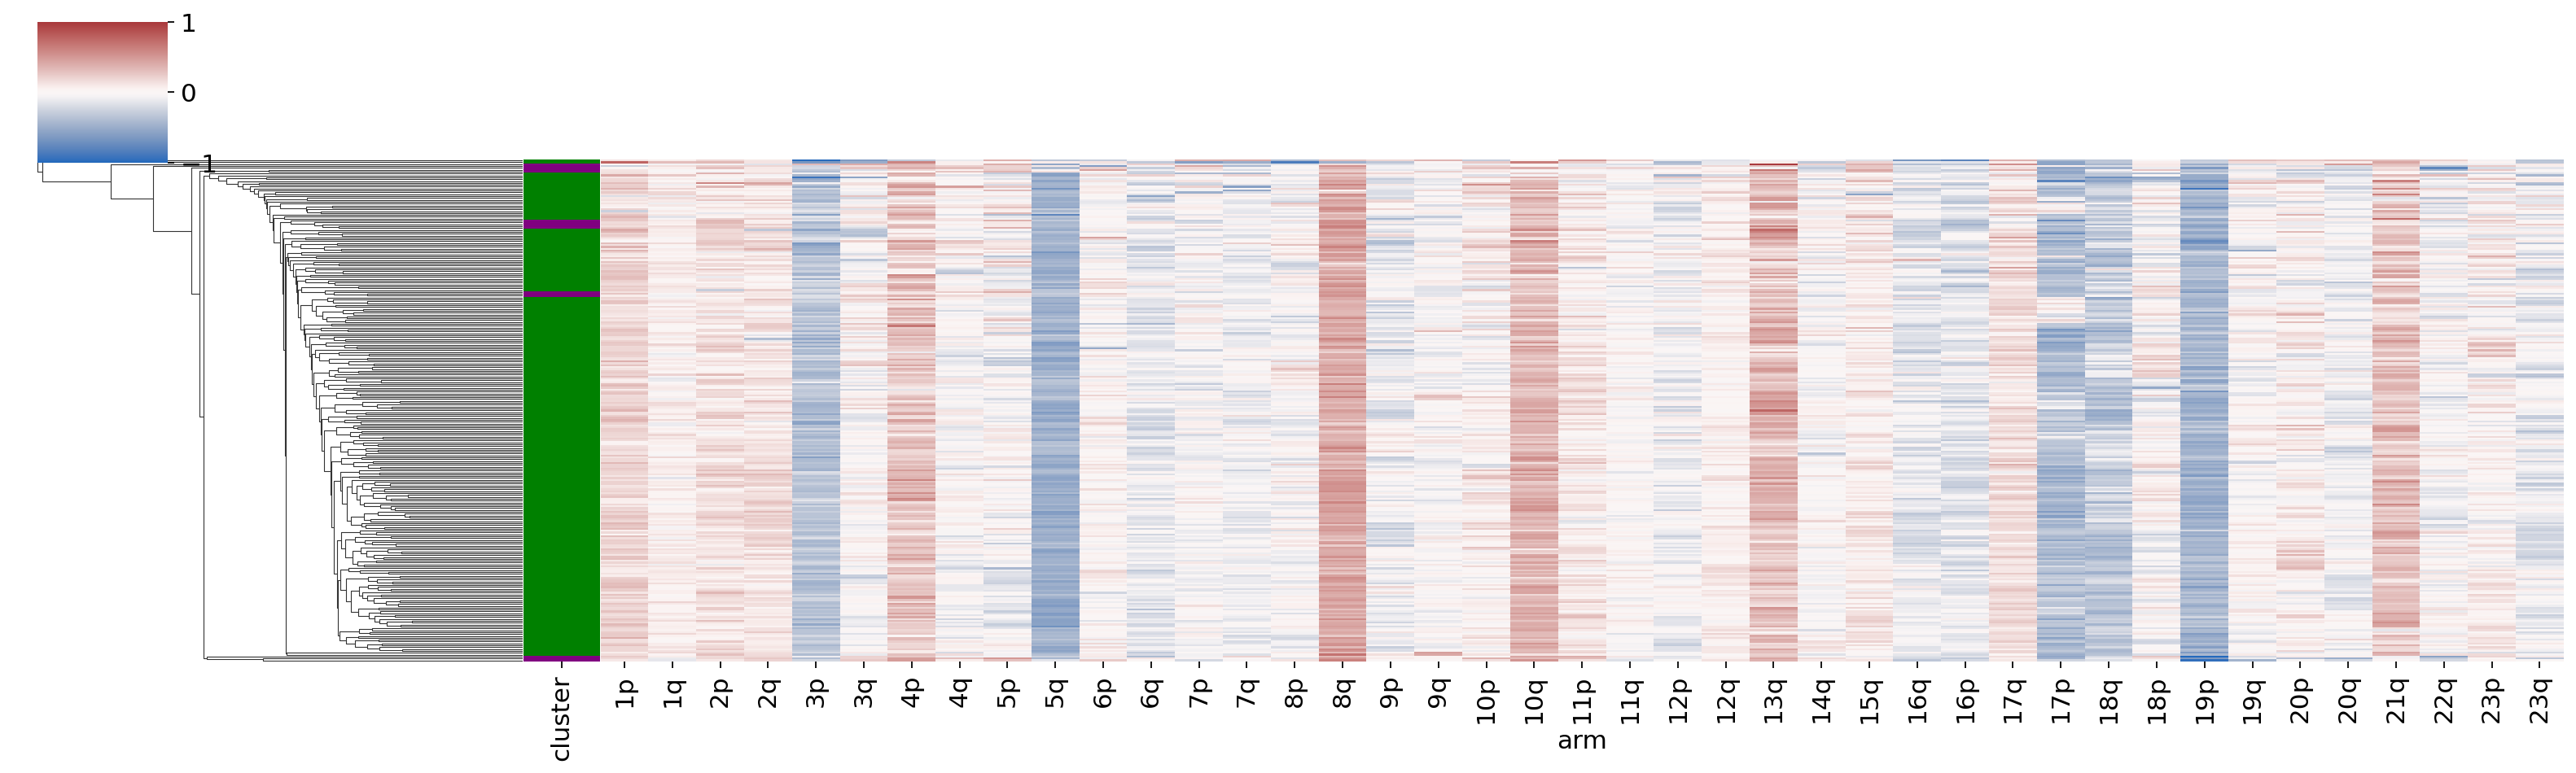

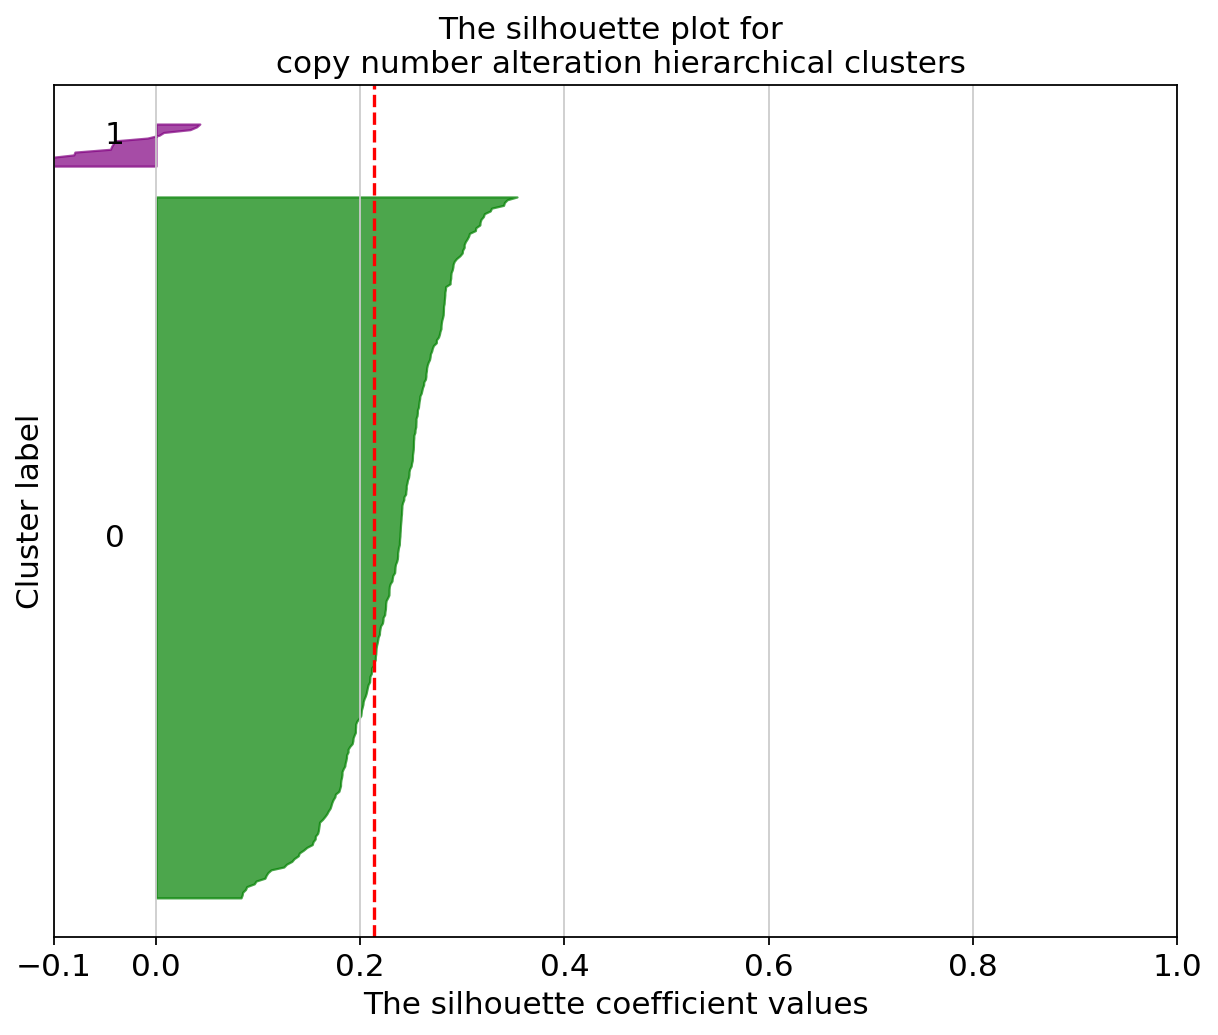

In [335]:
cluster_performance(p = 'NCIH1435_LUNG' ) ##no

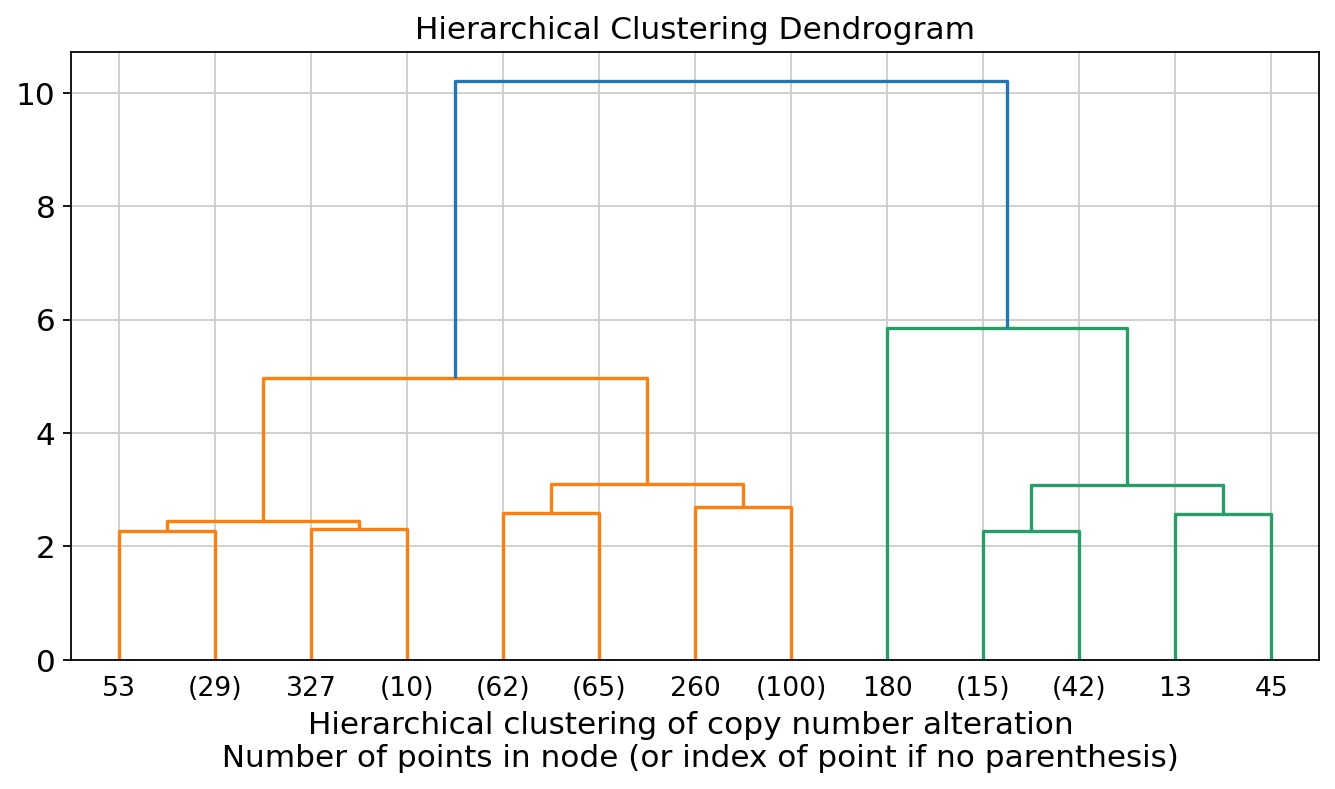

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


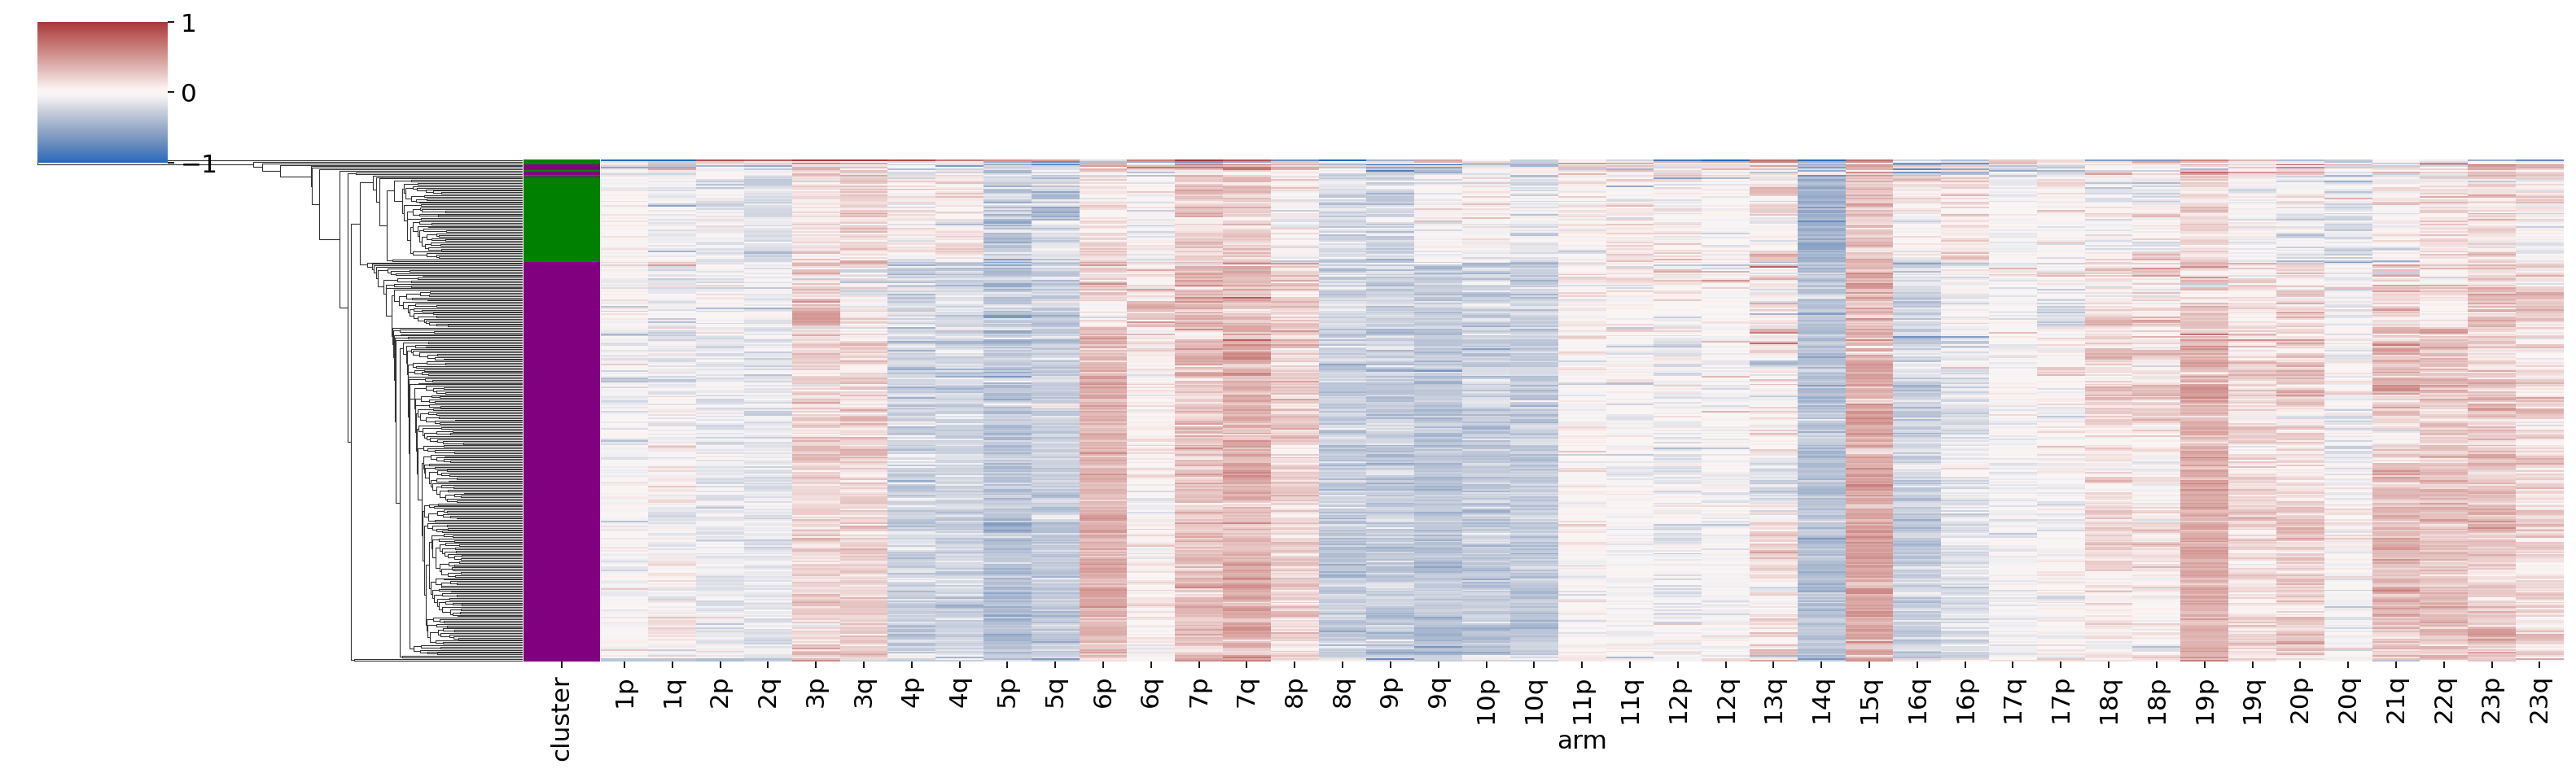

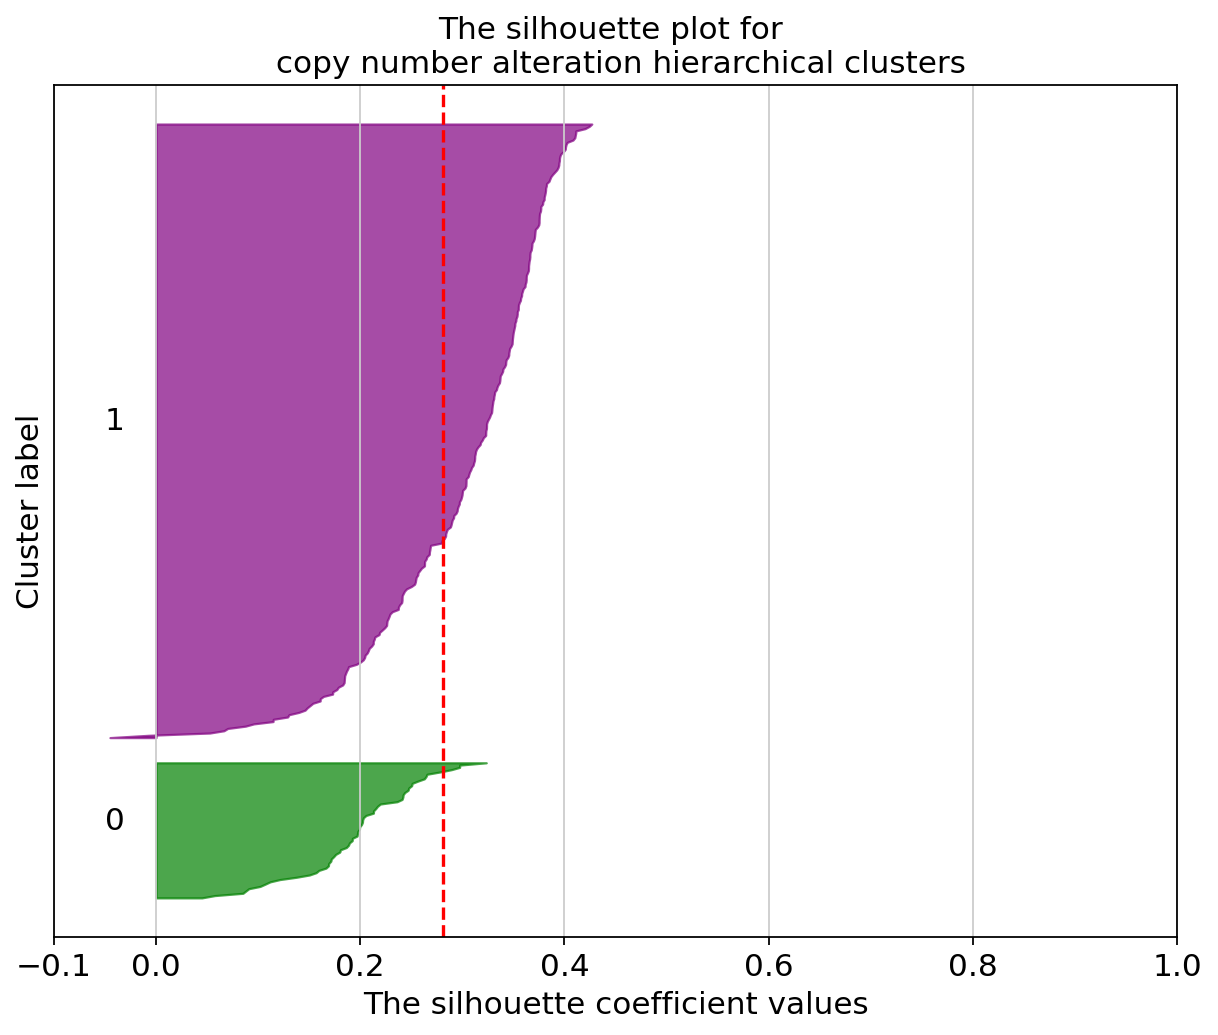

In [336]:
cluster_performance(p = 'COLO741_SKIN' )

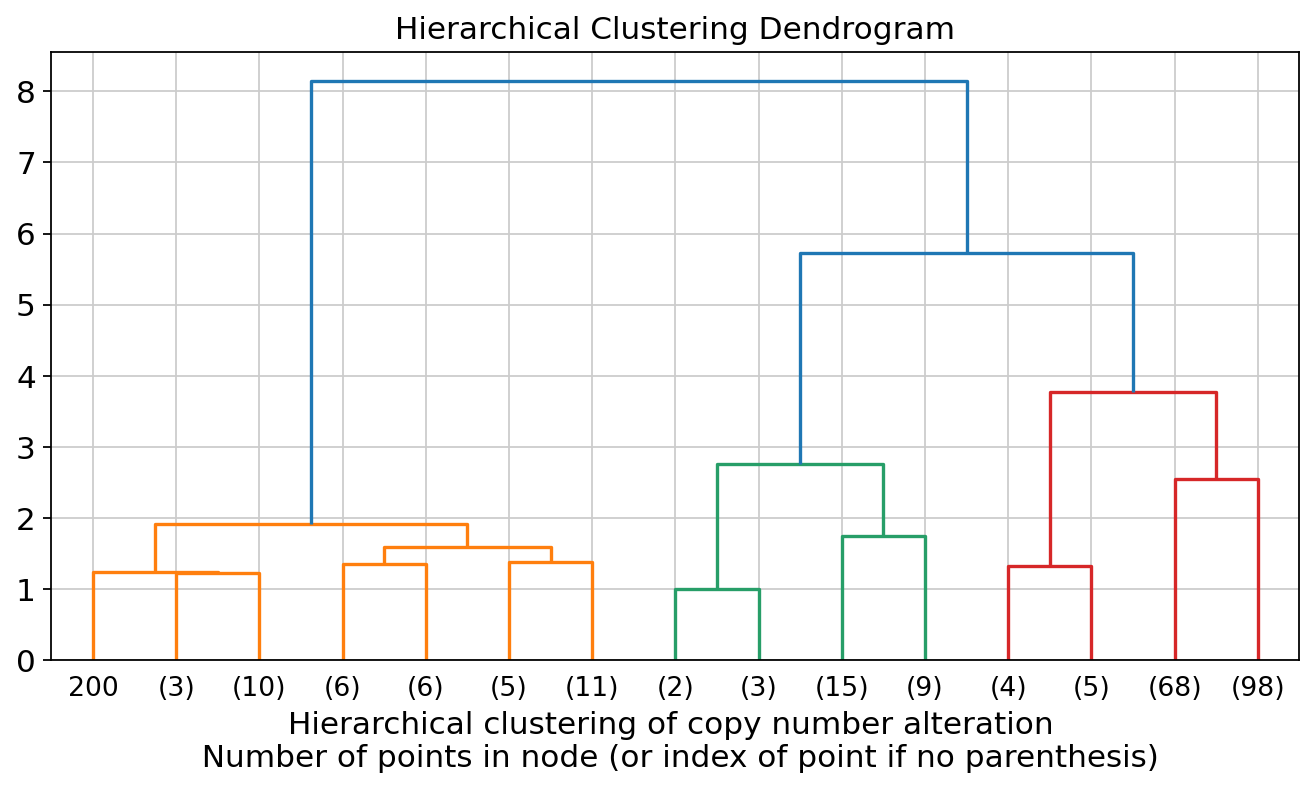

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


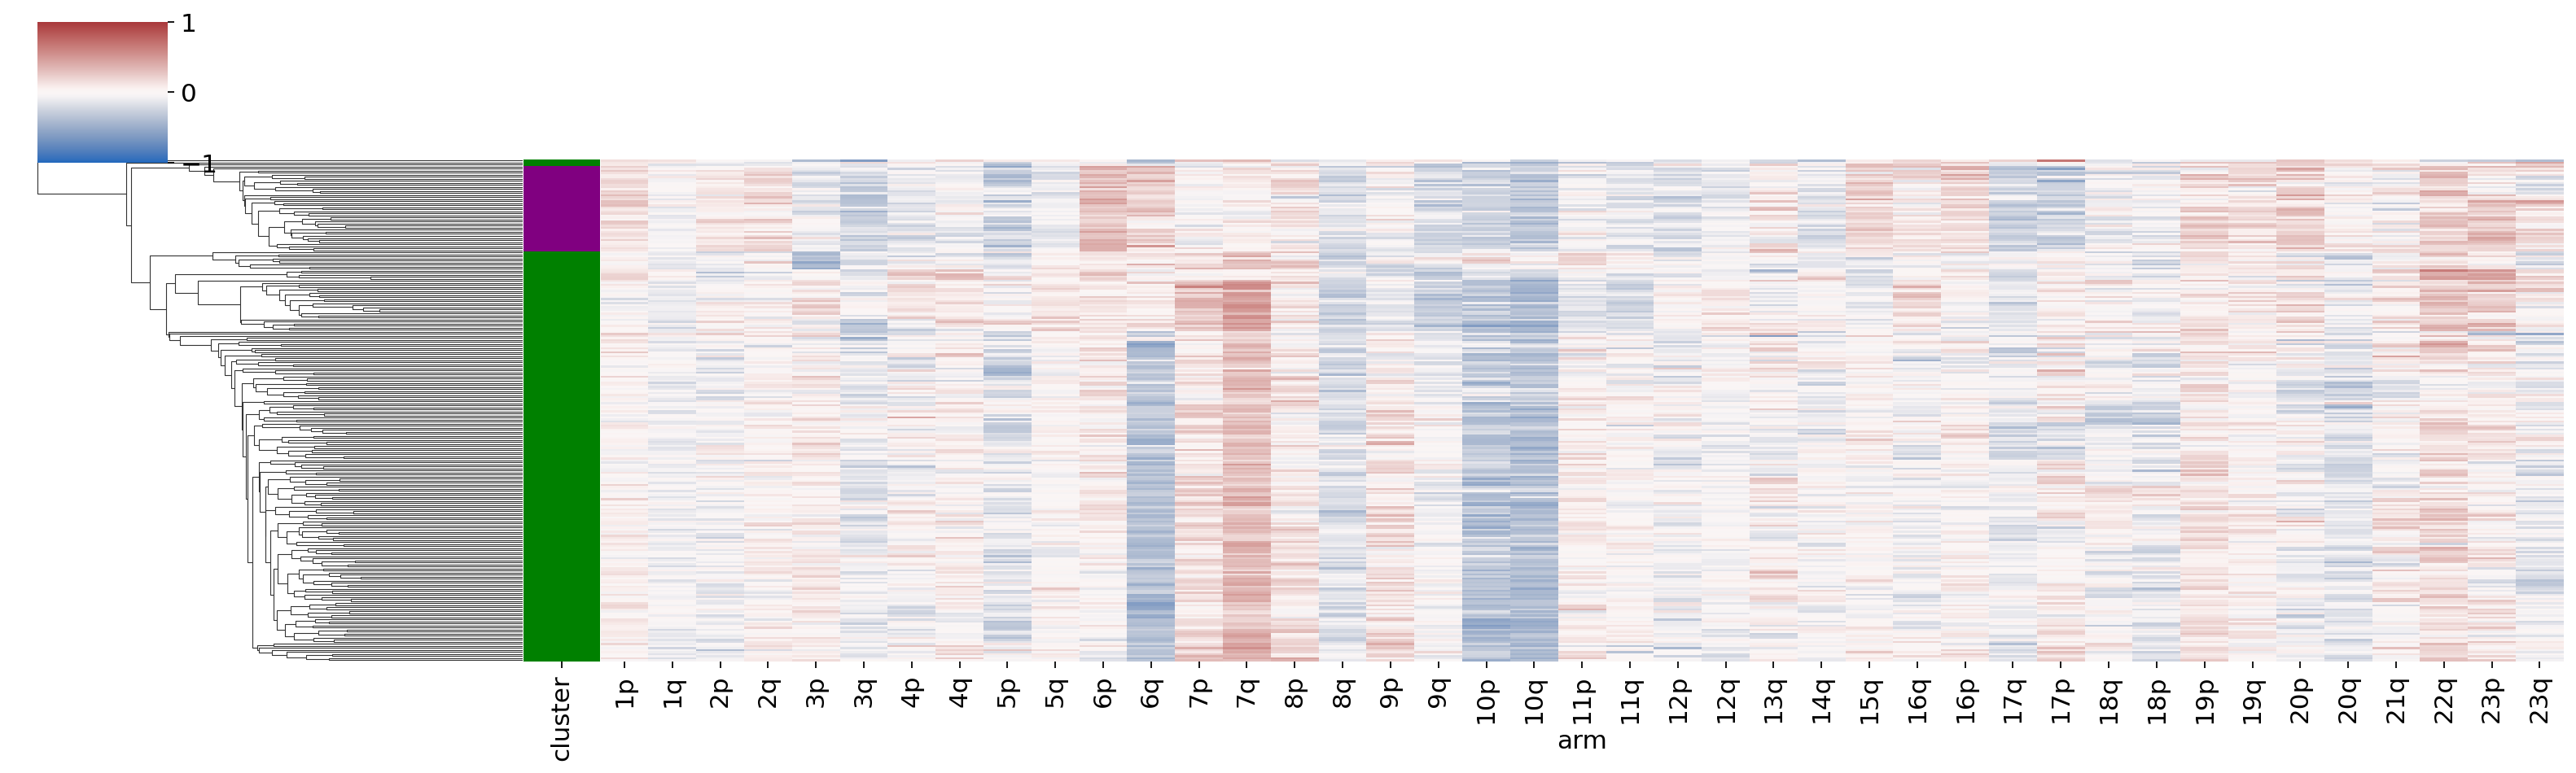

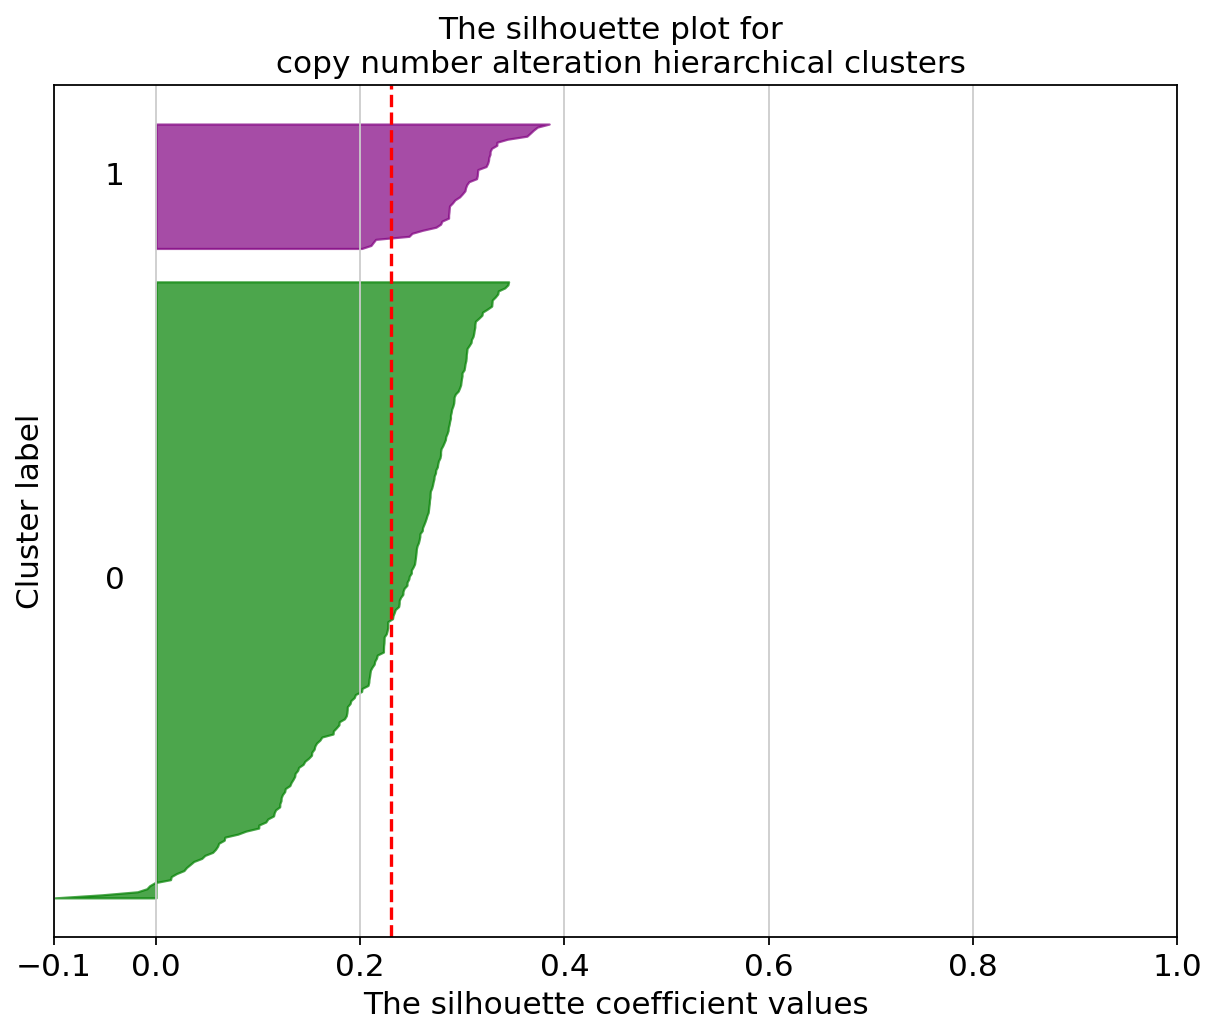

In [337]:
cluster_performance(p = 'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM' ) ##could have three clusters

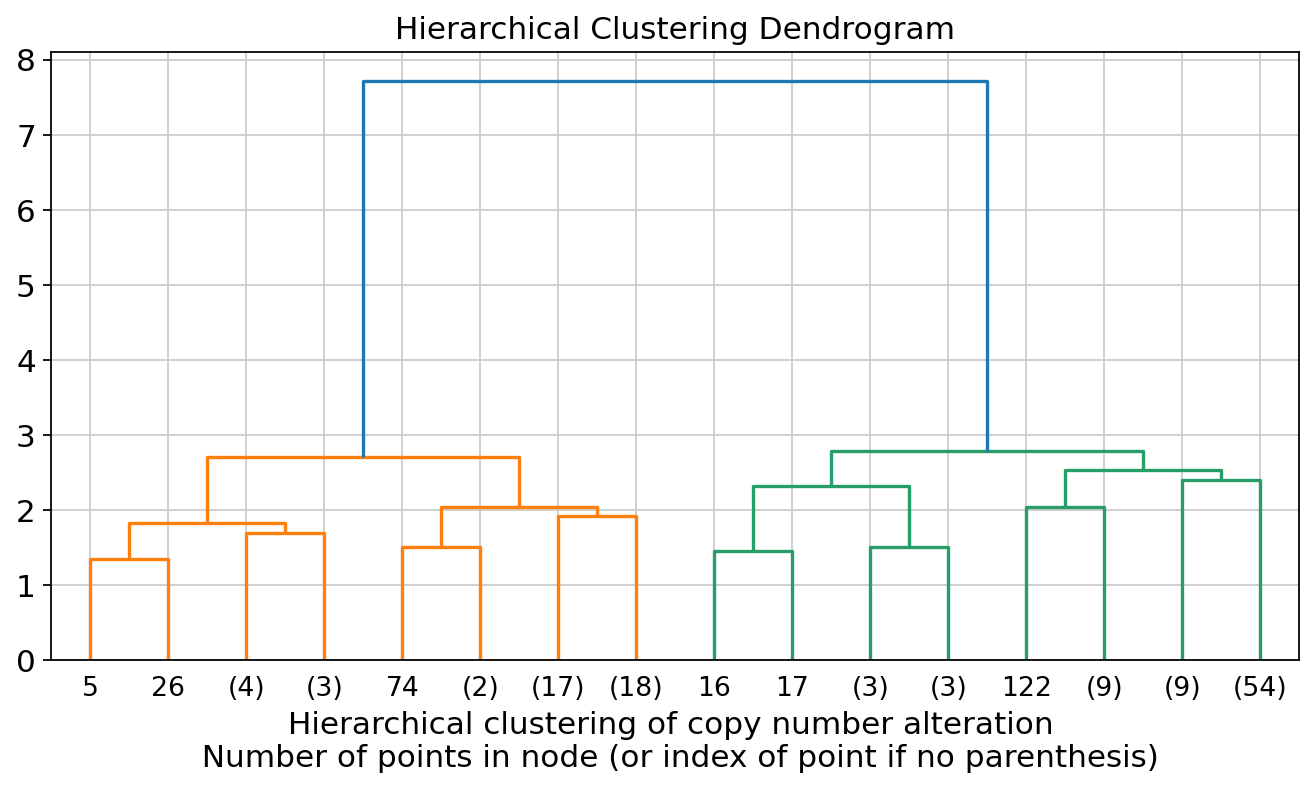

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

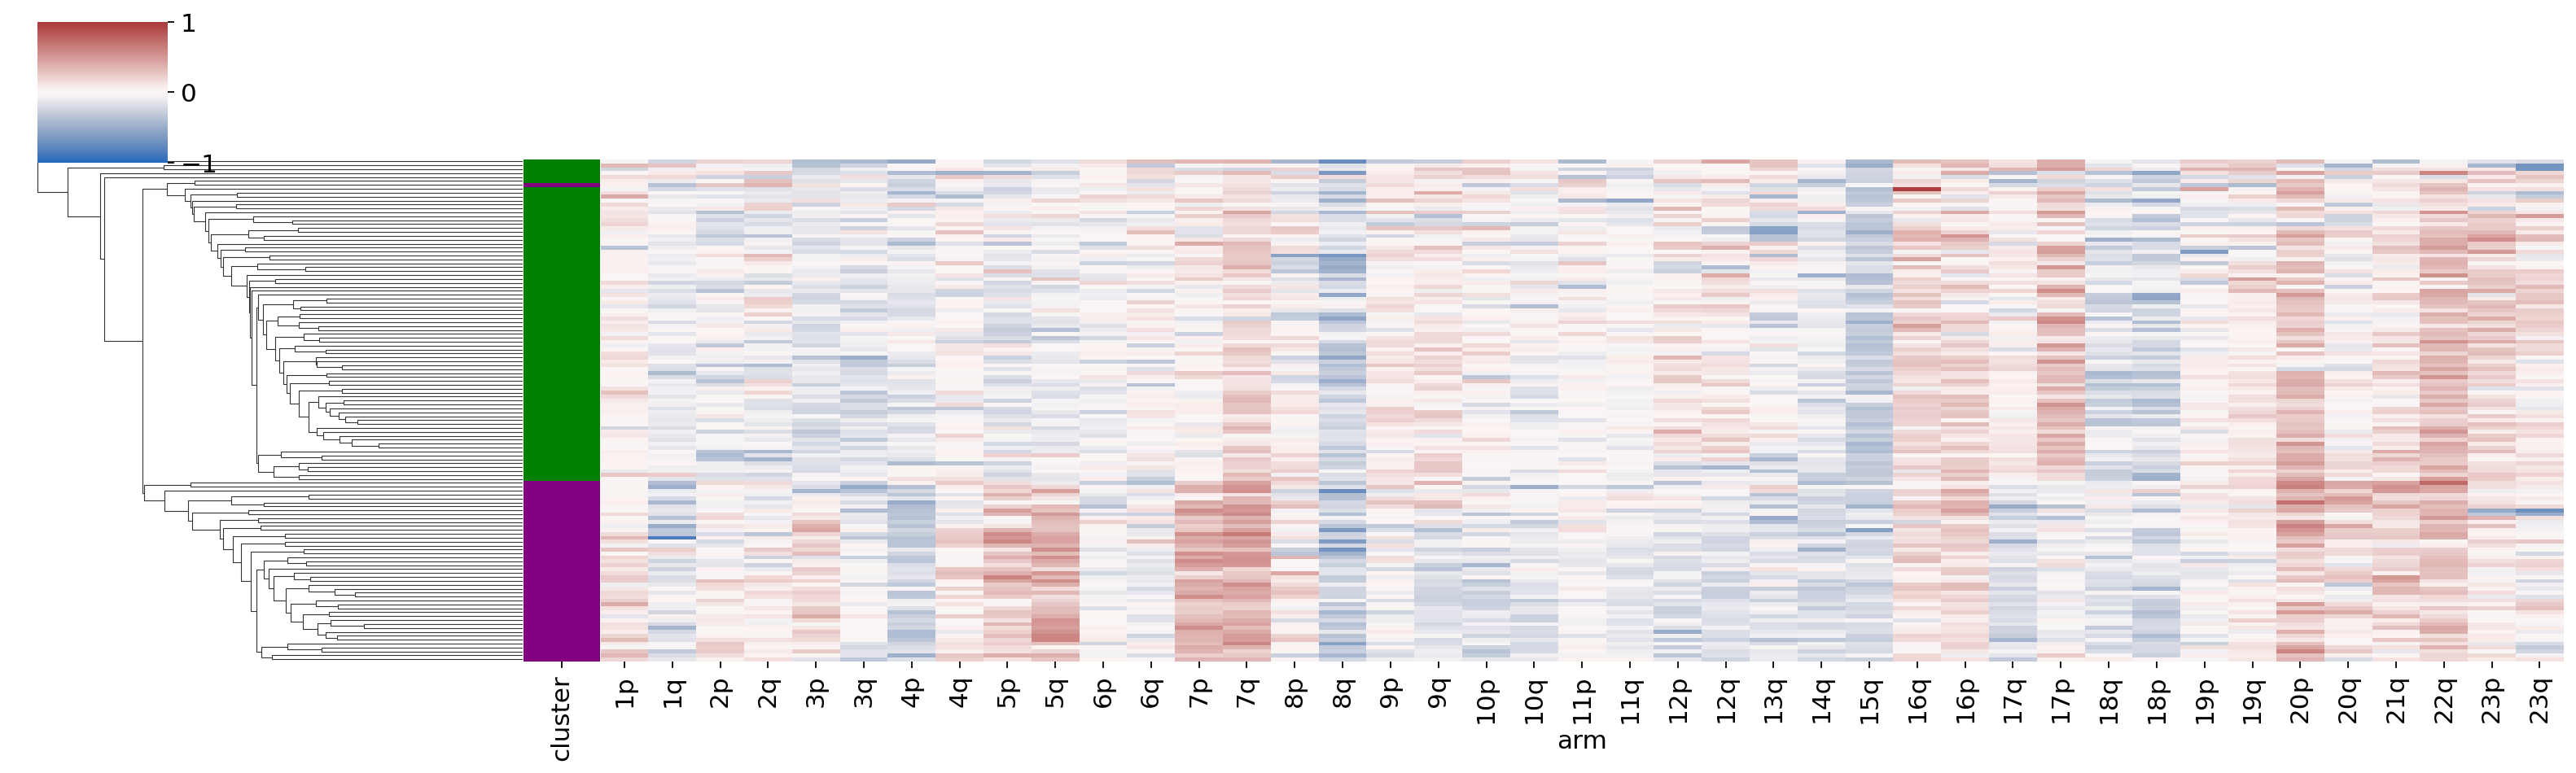

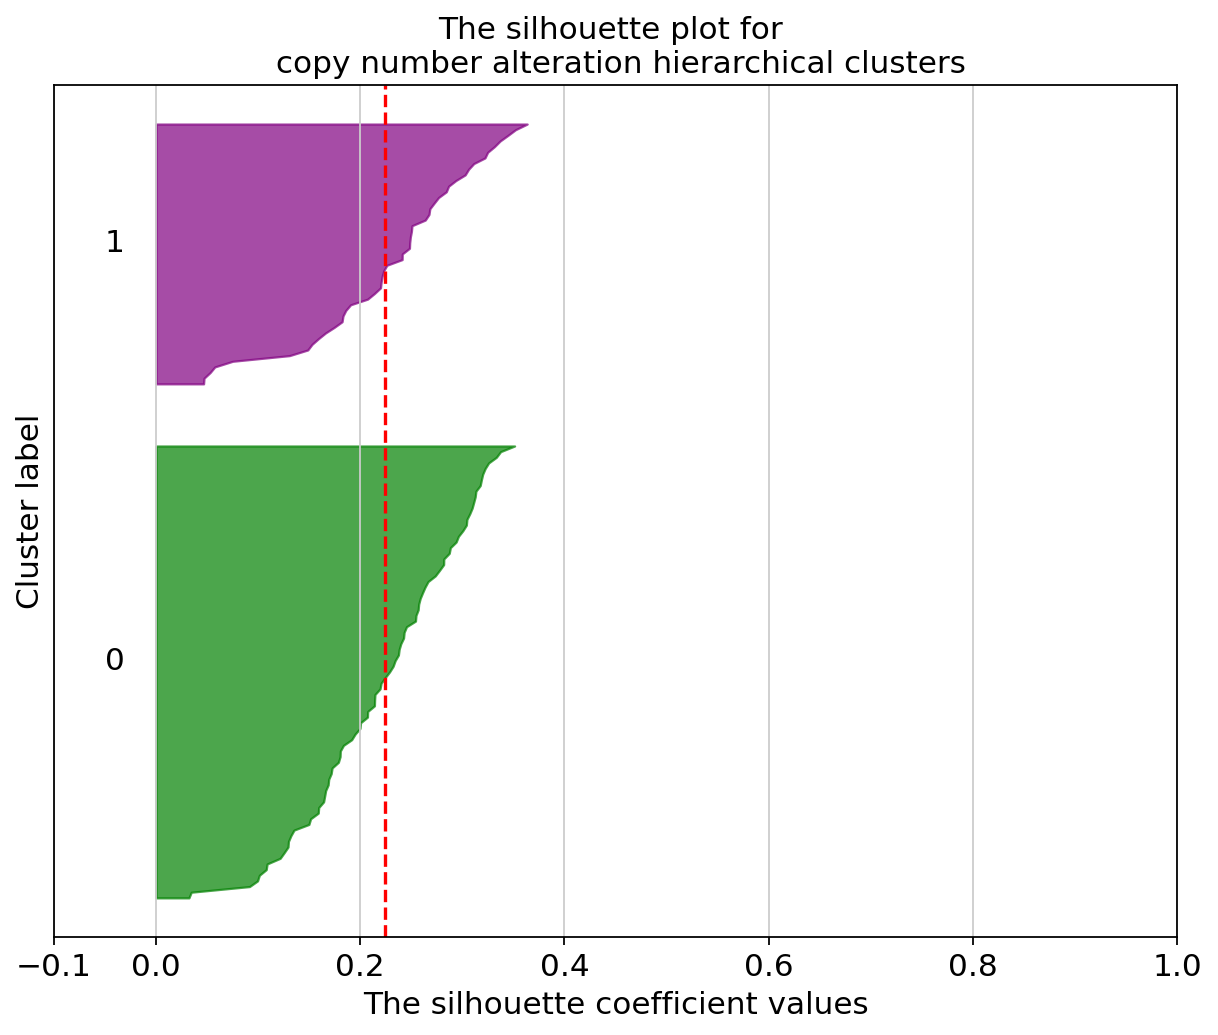

In [338]:
cluster_performance(p = 'SW1088_CENTRAL_NERVOUS_SYSTEM' ) ##interesting

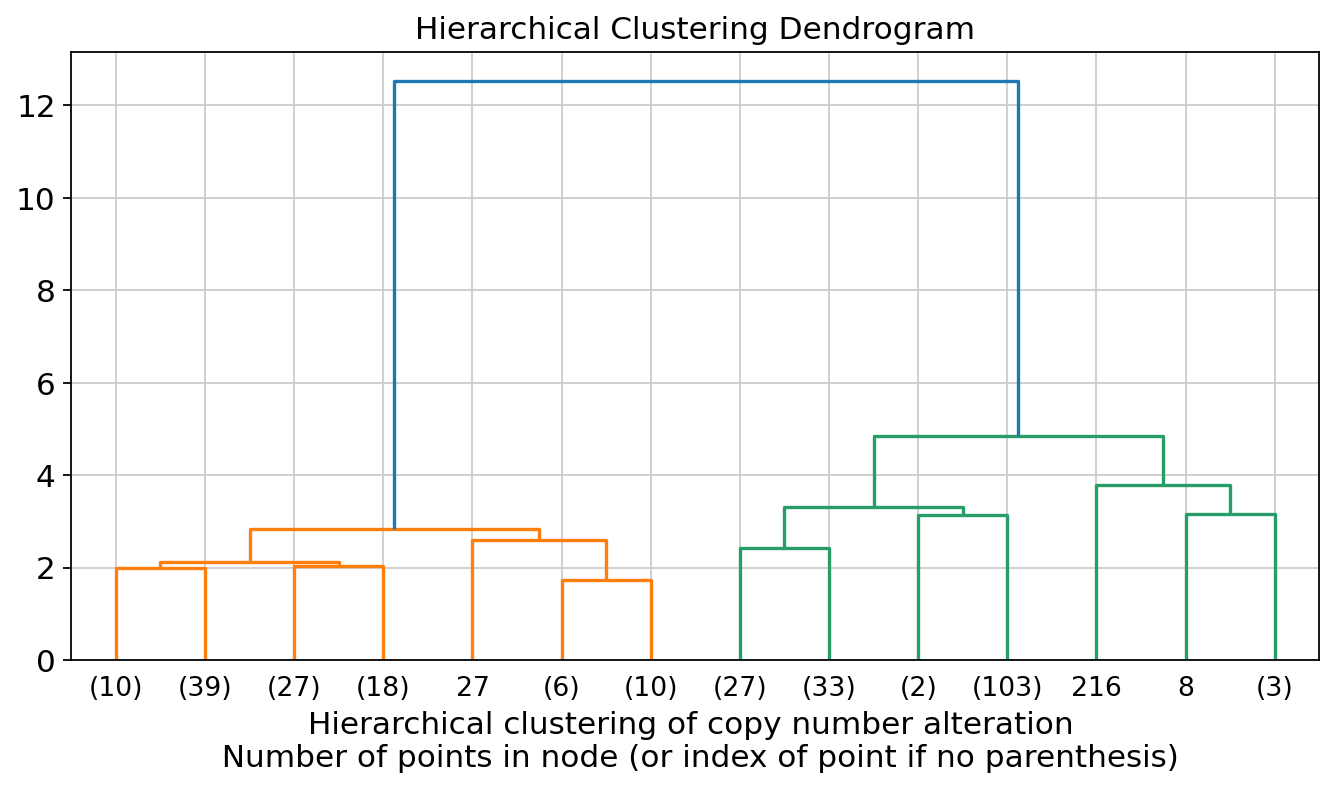

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


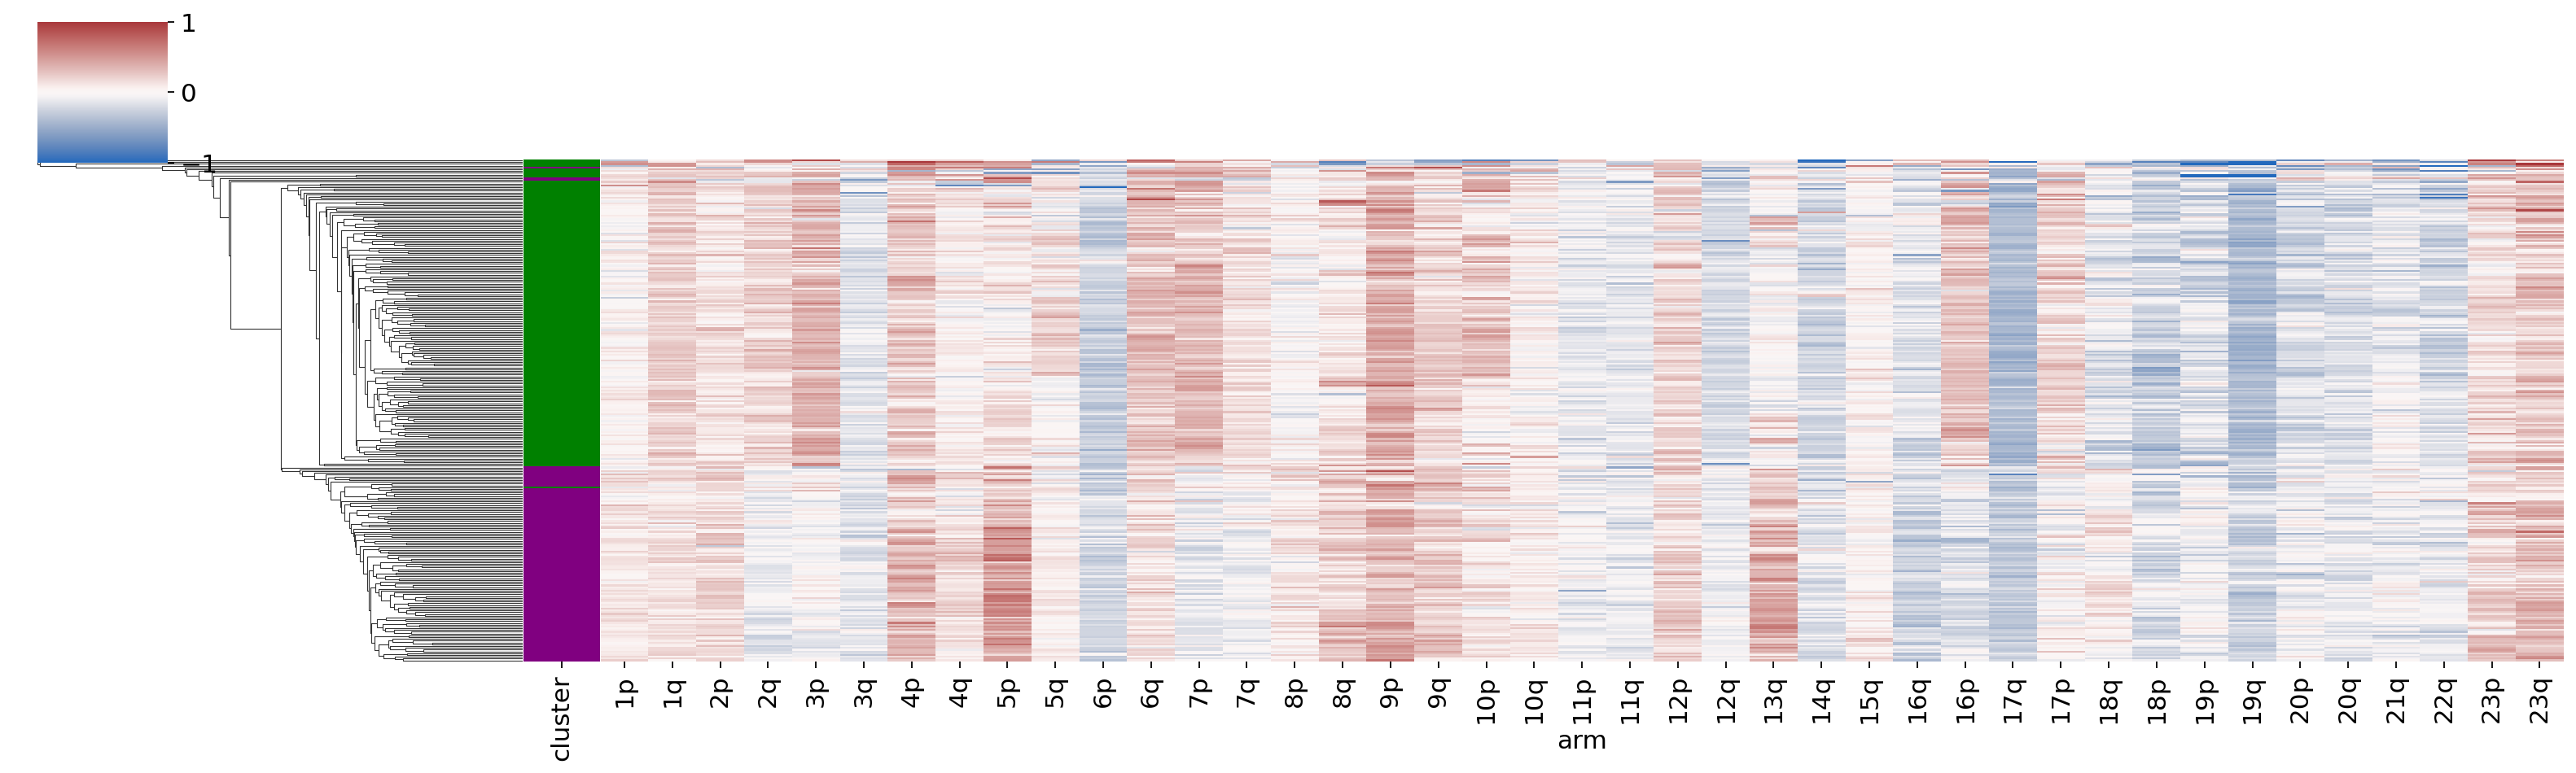

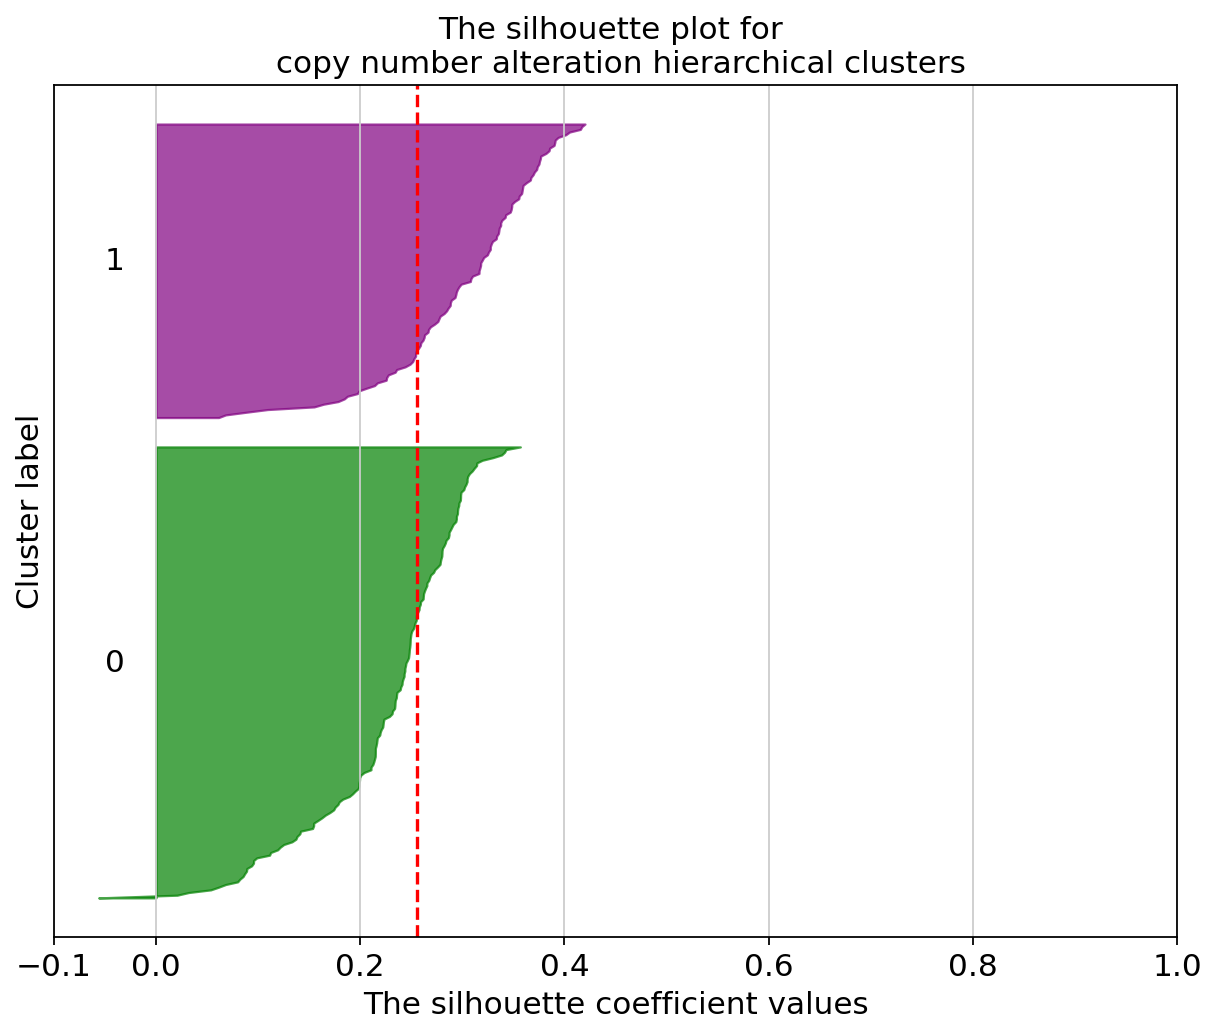

In [339]:
cluster_performance(p = 'MDAMB436_BREAST' ) ##interesting

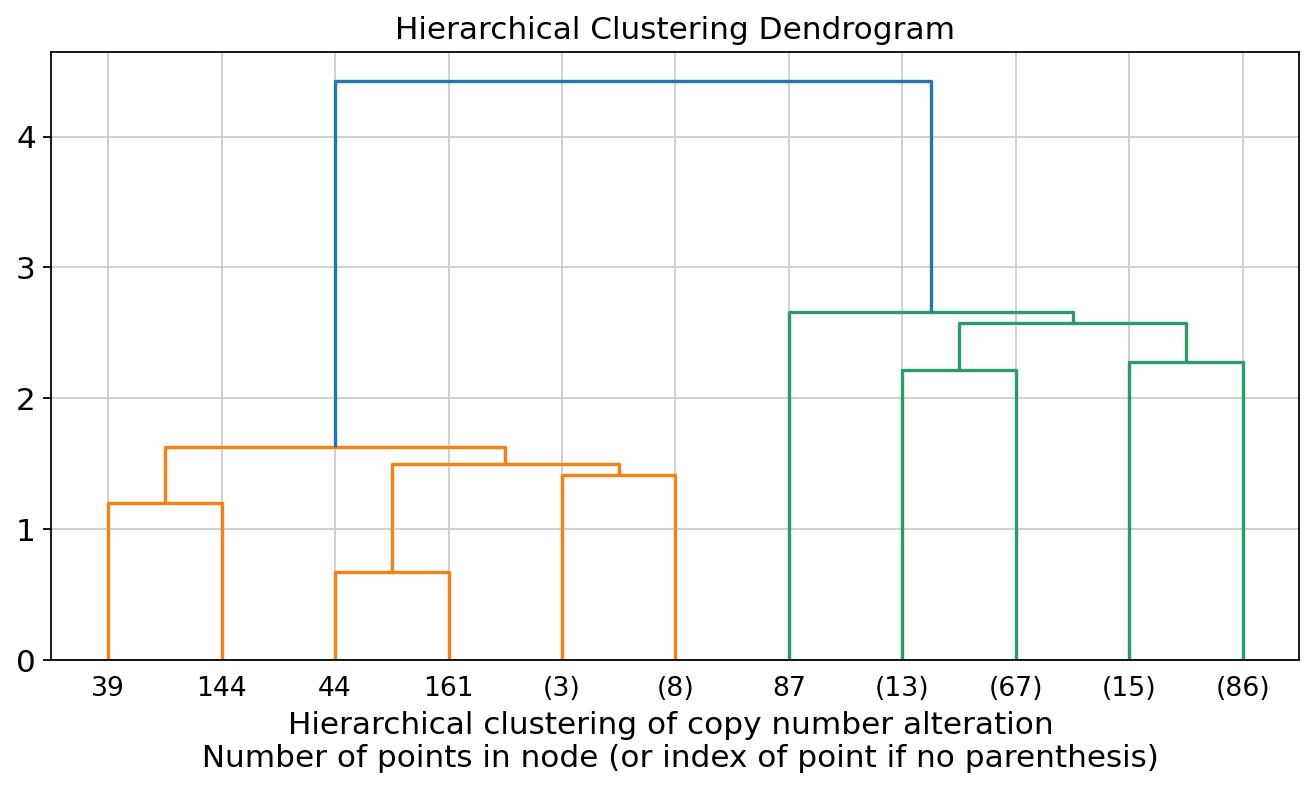

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

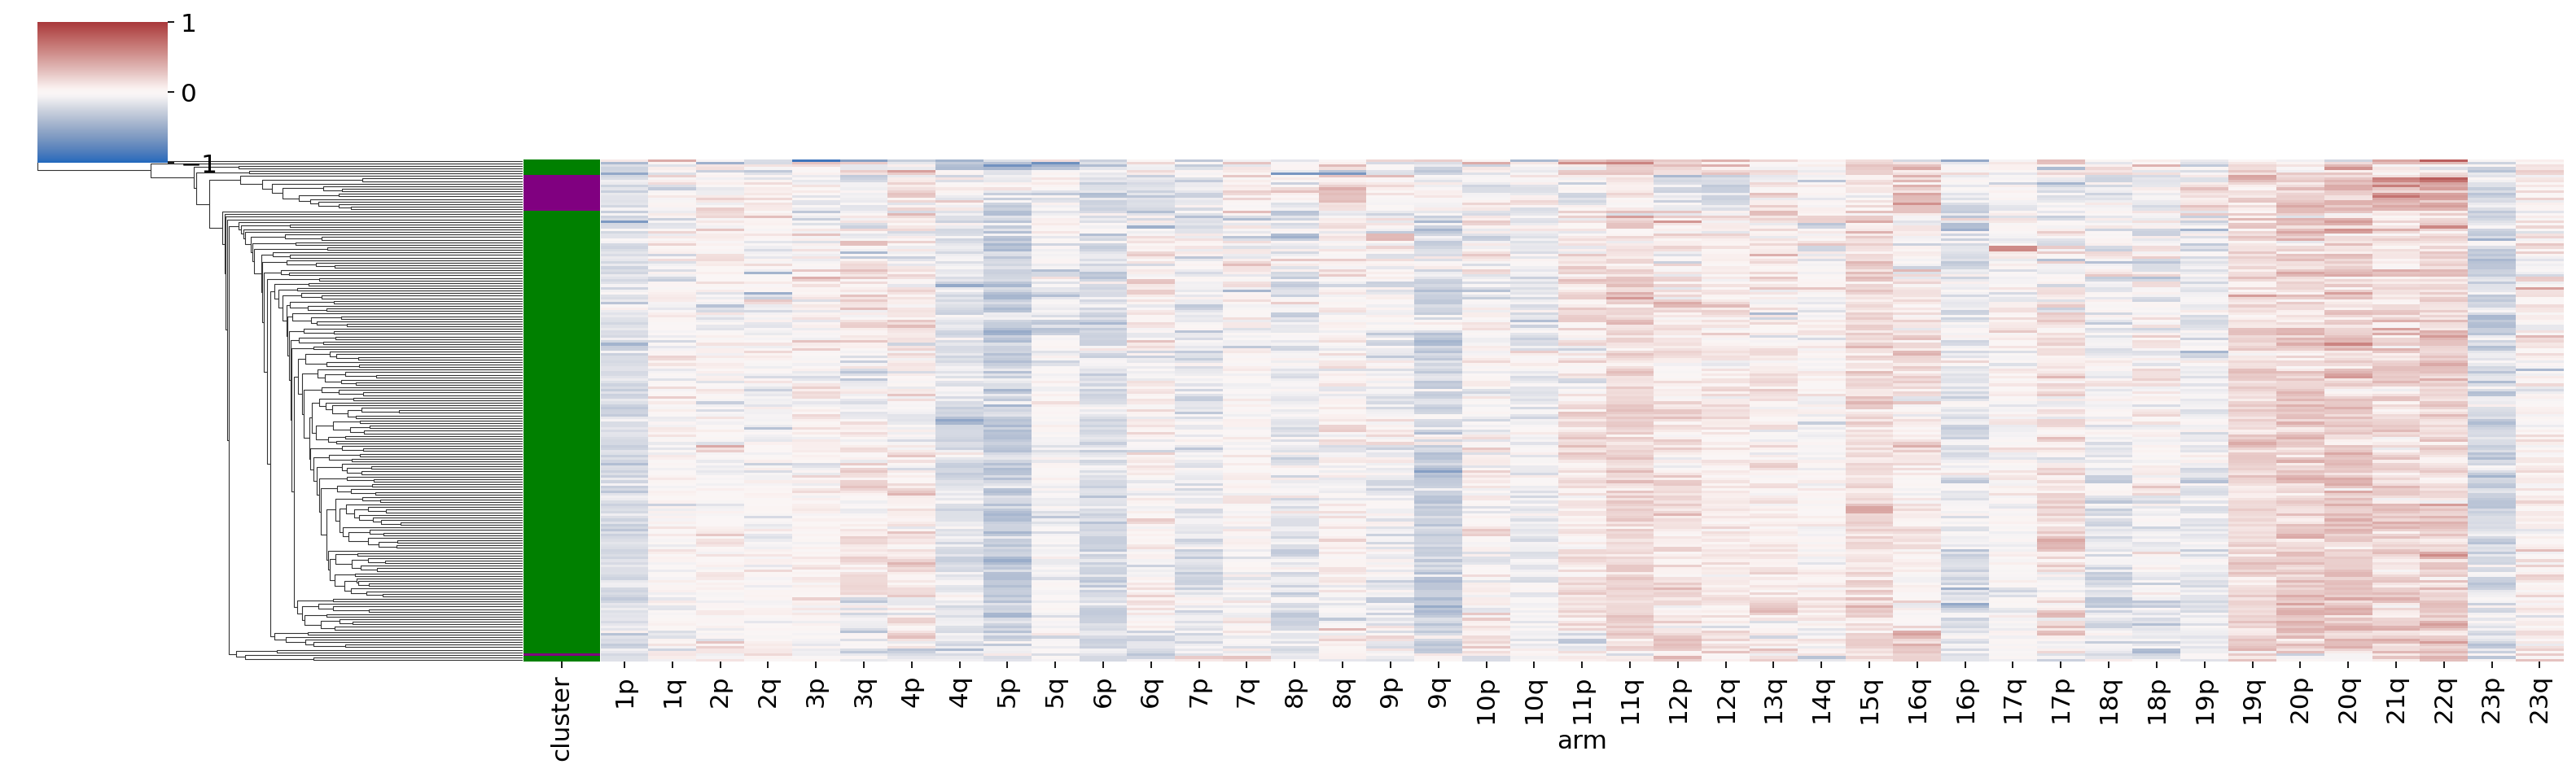

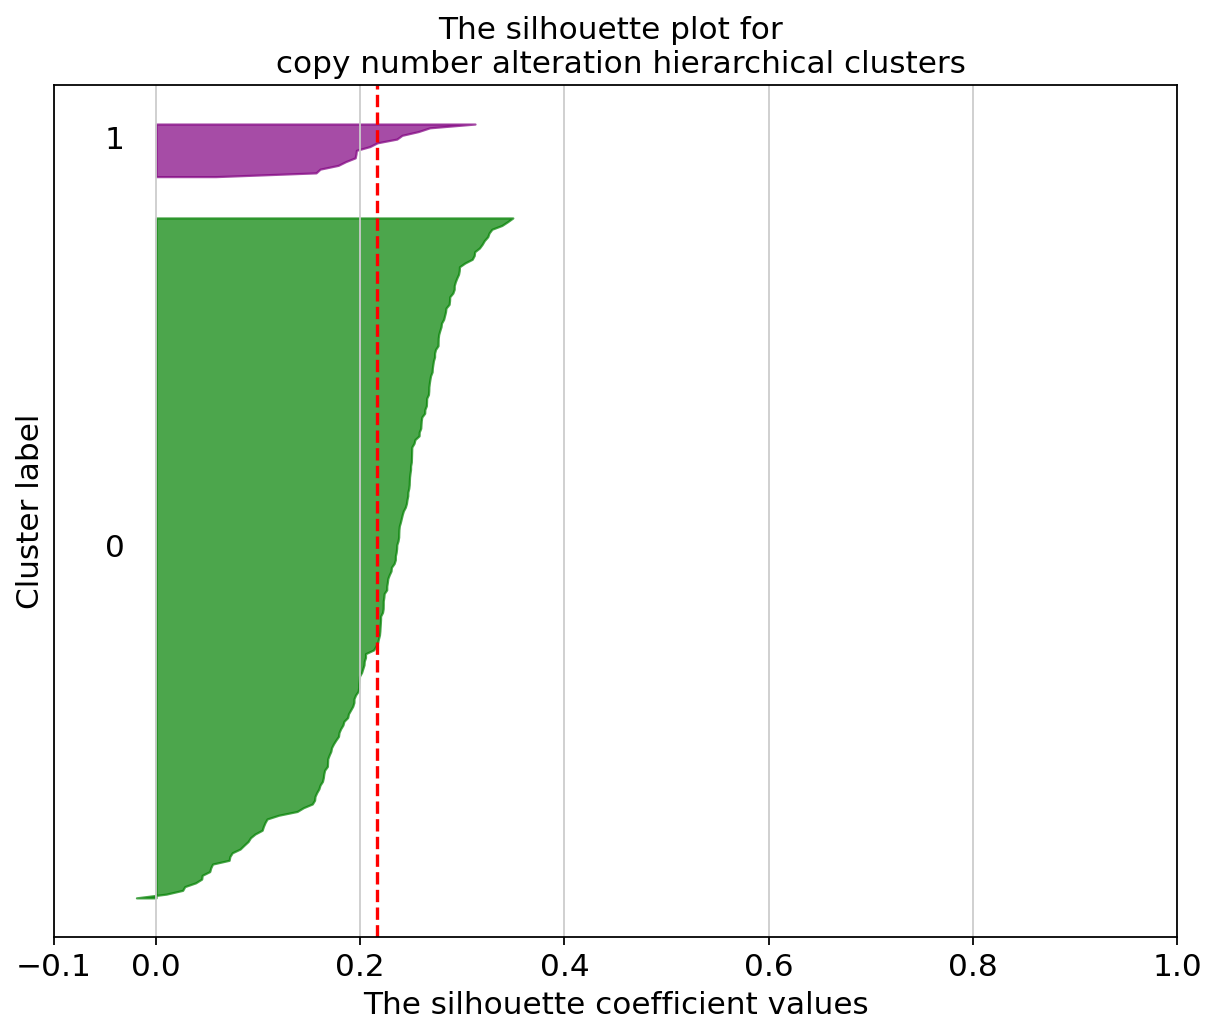

In [340]:
cluster_performance(p = 'UMUC1_URINARY_TRACT' ) ##may not be as significant

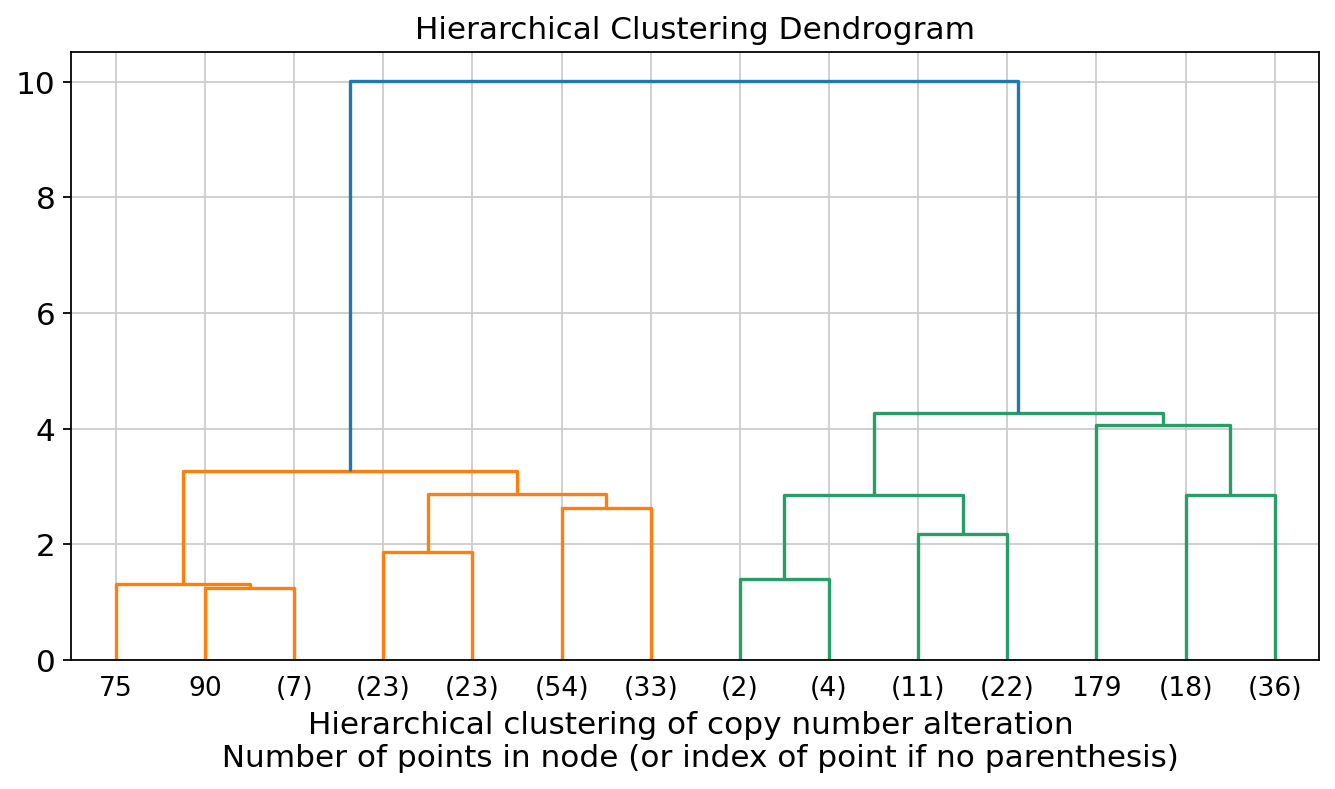

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

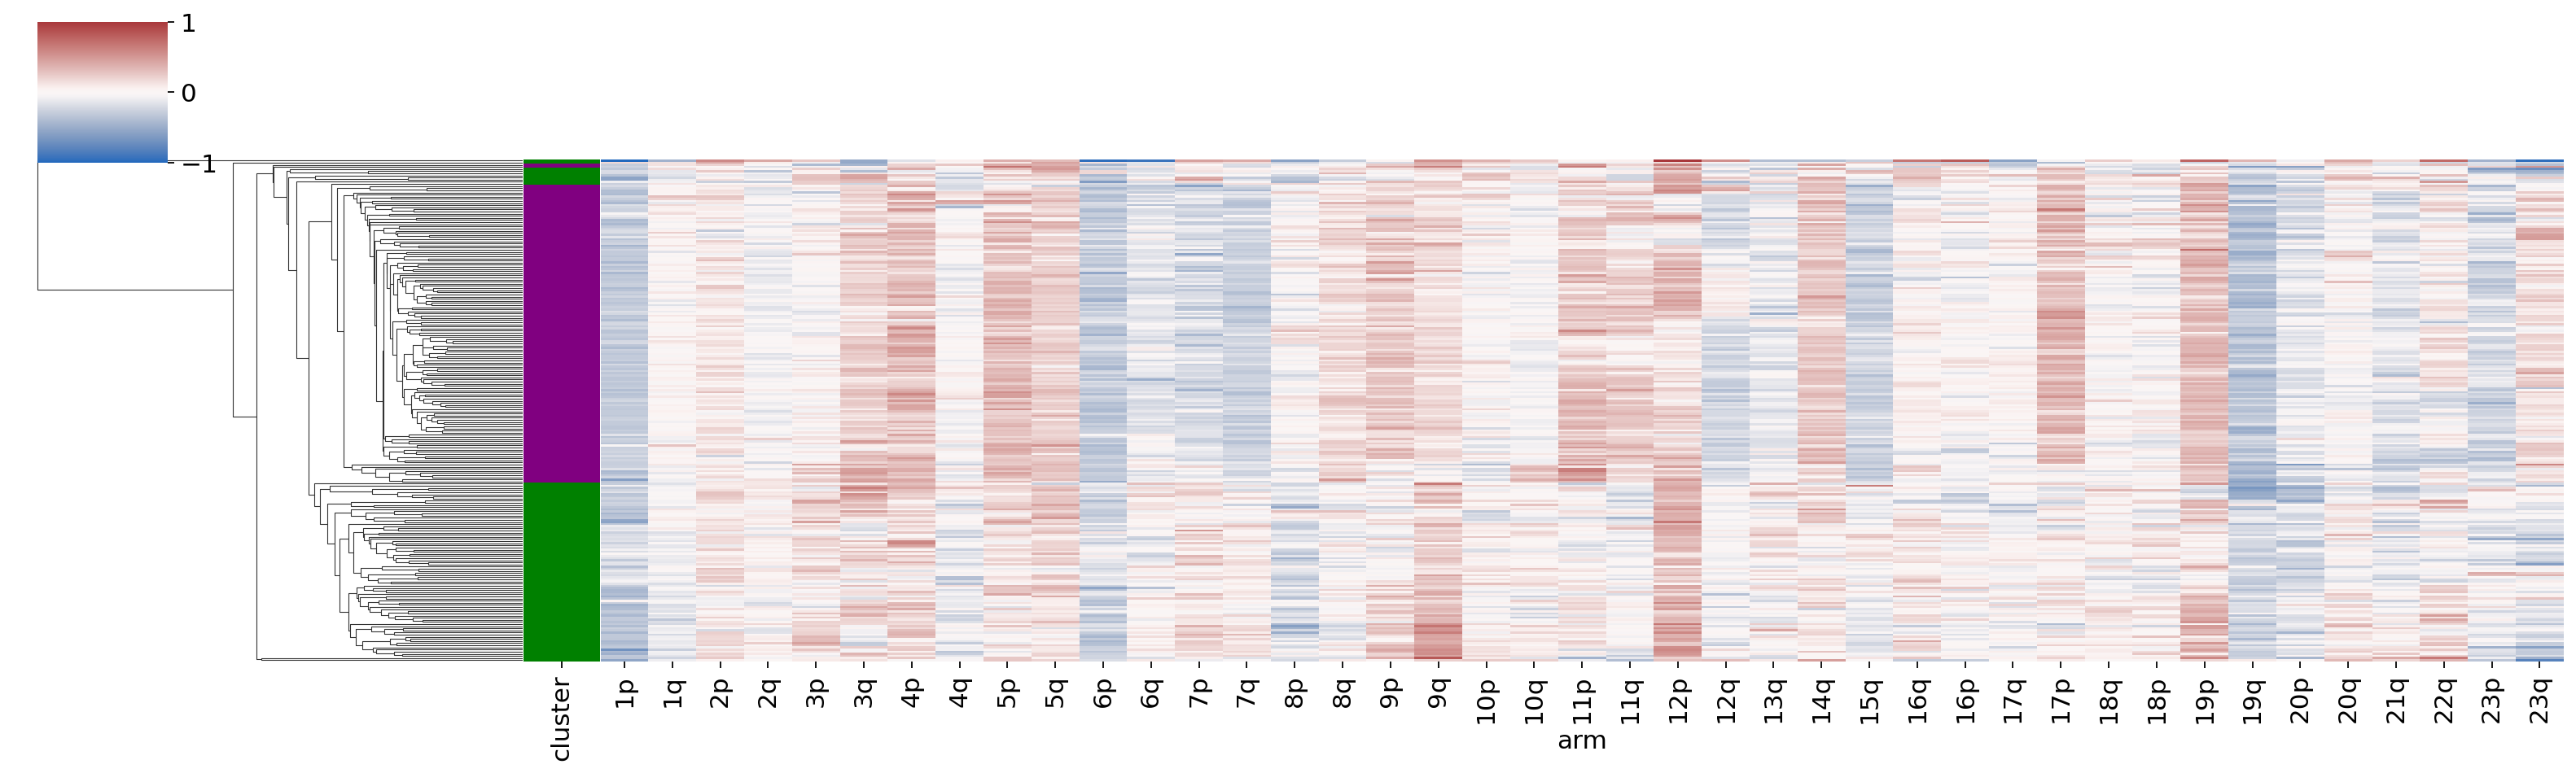

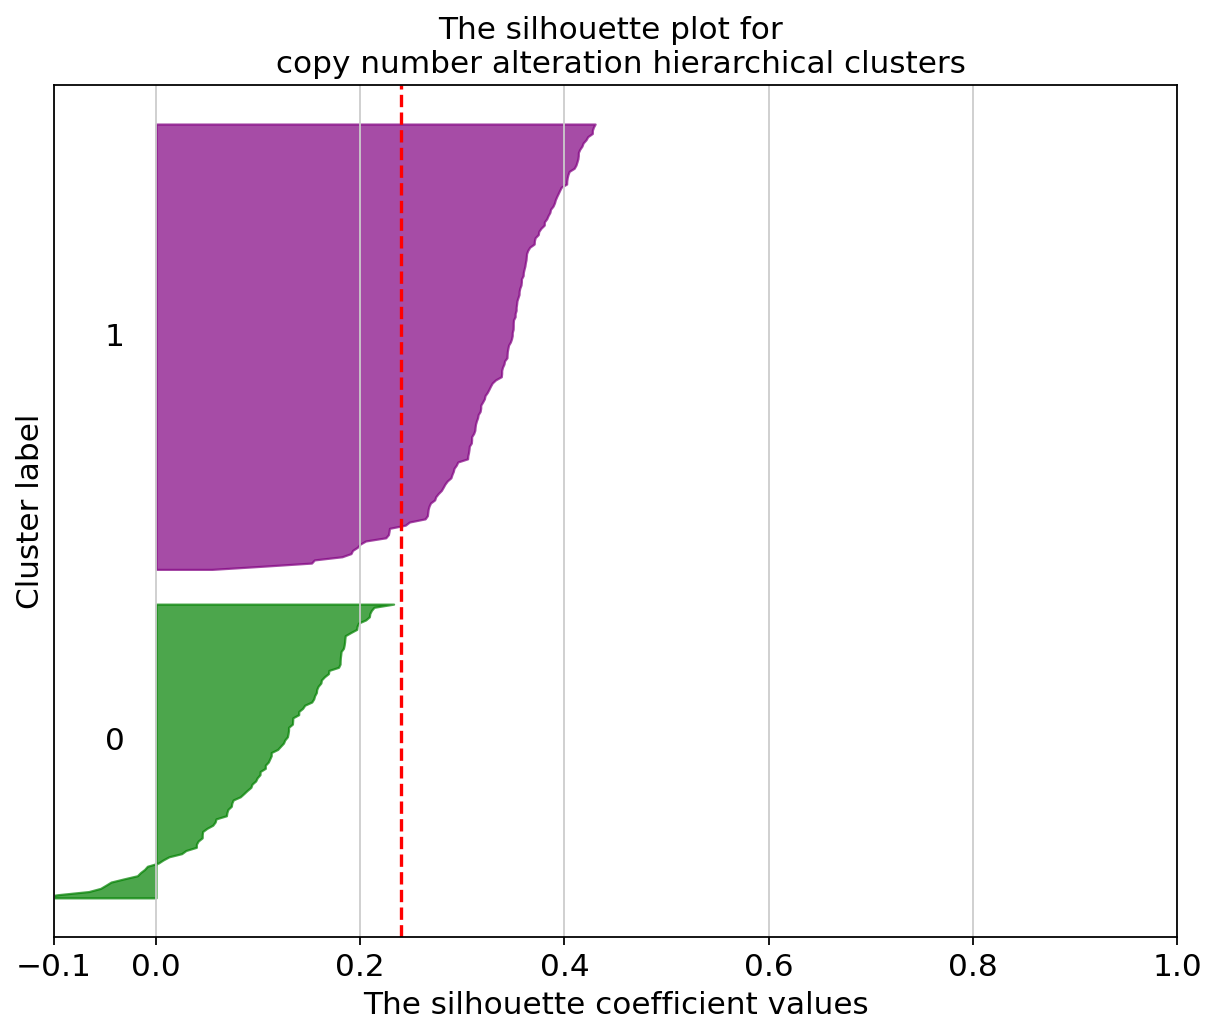

In [341]:
cluster_performance(p = 'SNU46_UPPER_AERODIGESTIVE_TRACT' ) ##may not be as significant

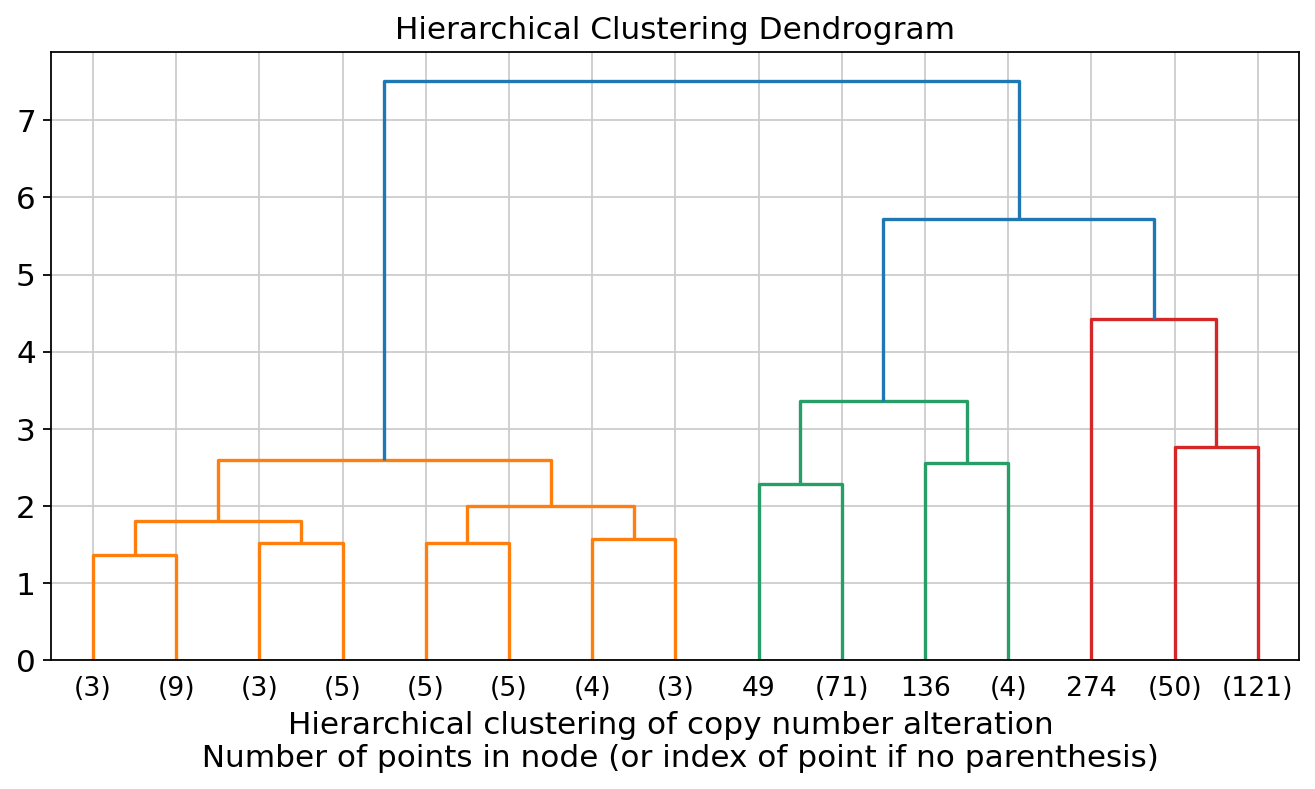

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


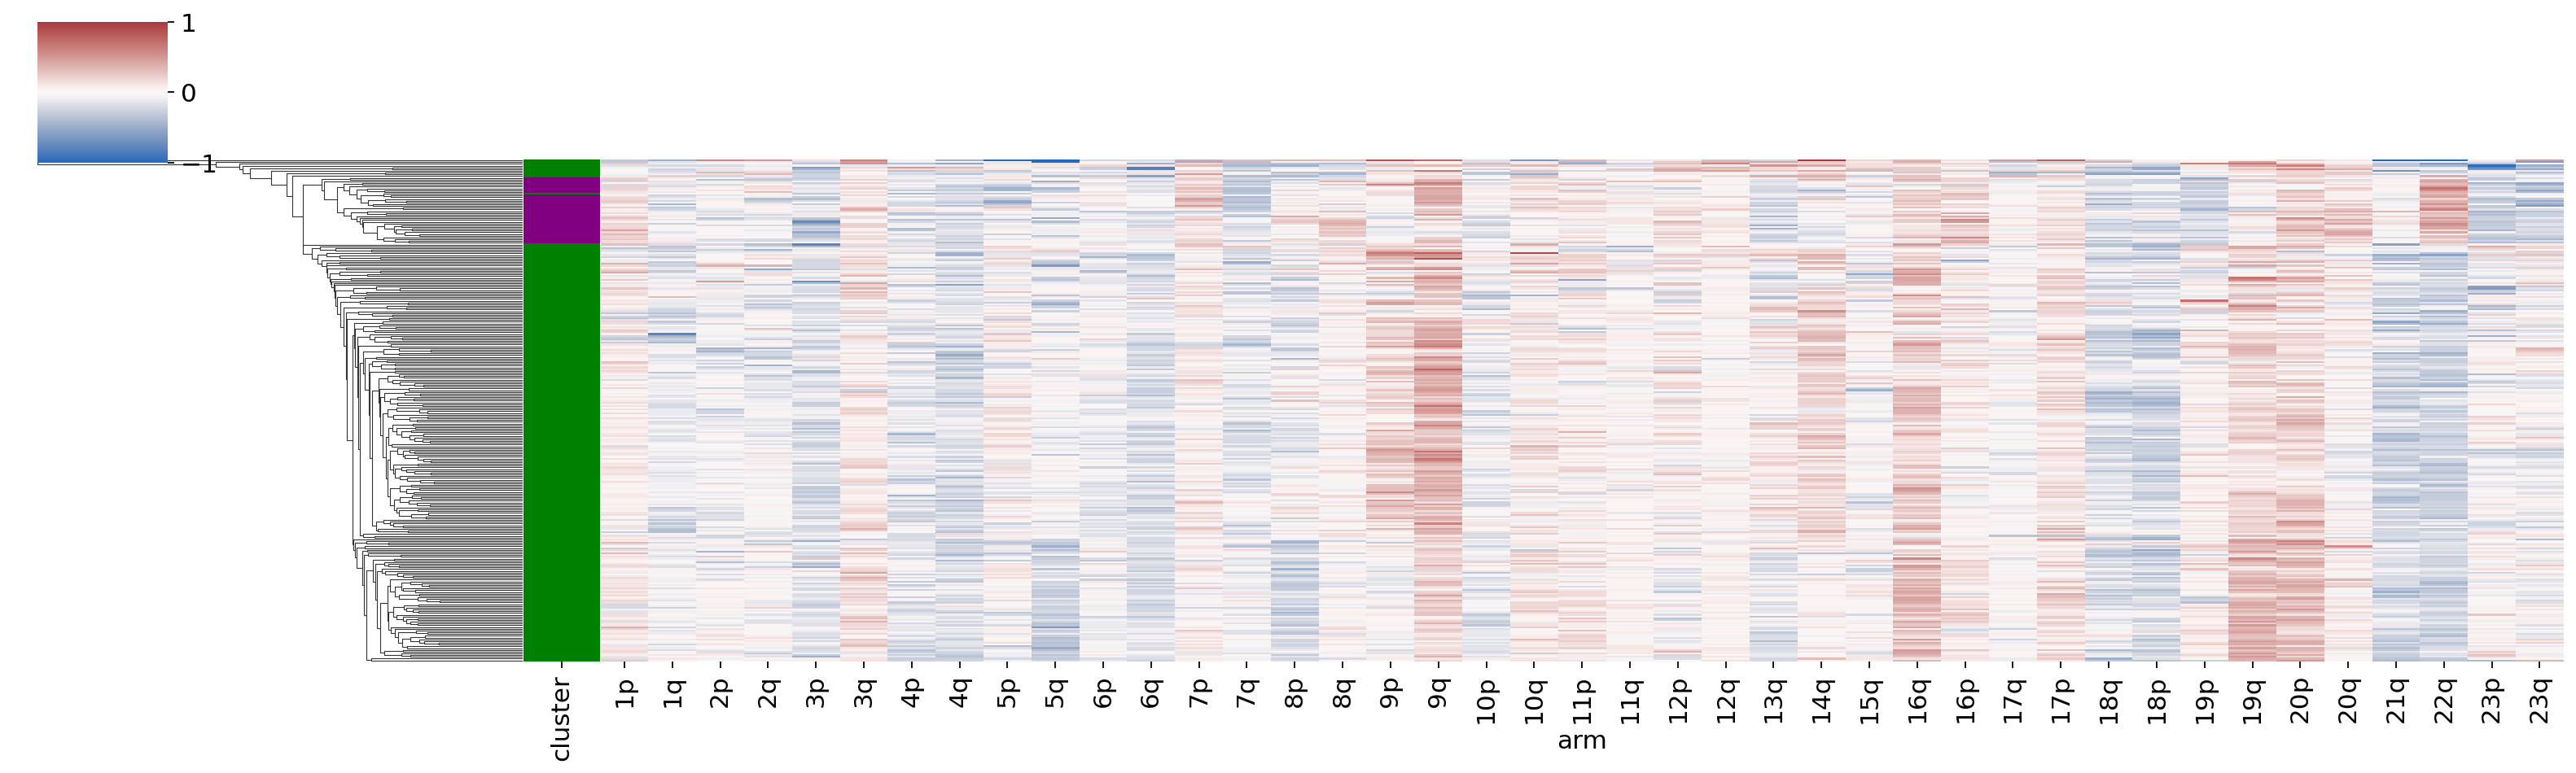

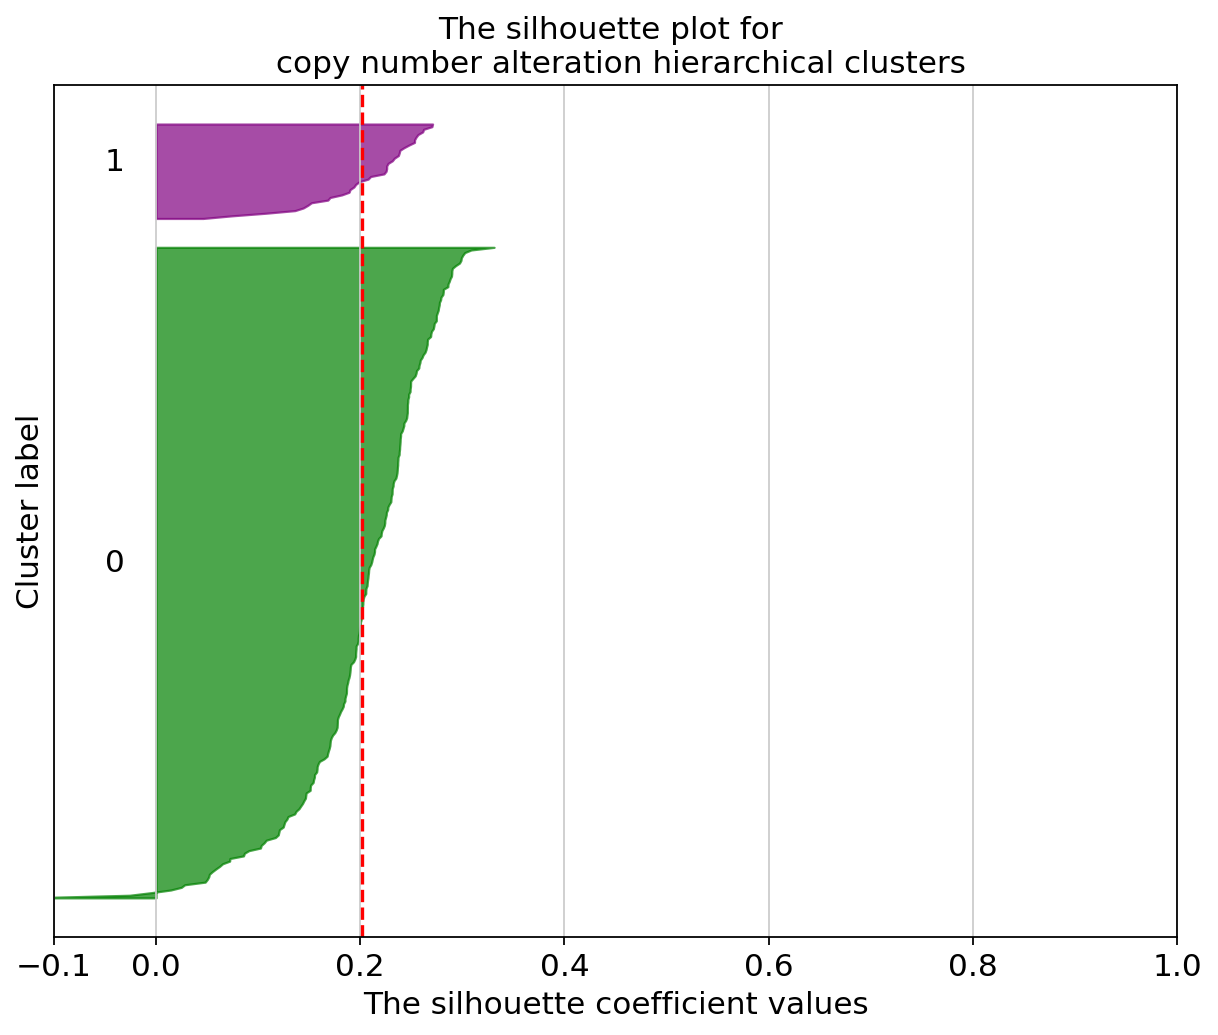

In [342]:
cluster_performance(p = 'BICR6_UPPER_AERODIGESTIVE_TRACT' ) ##could have three

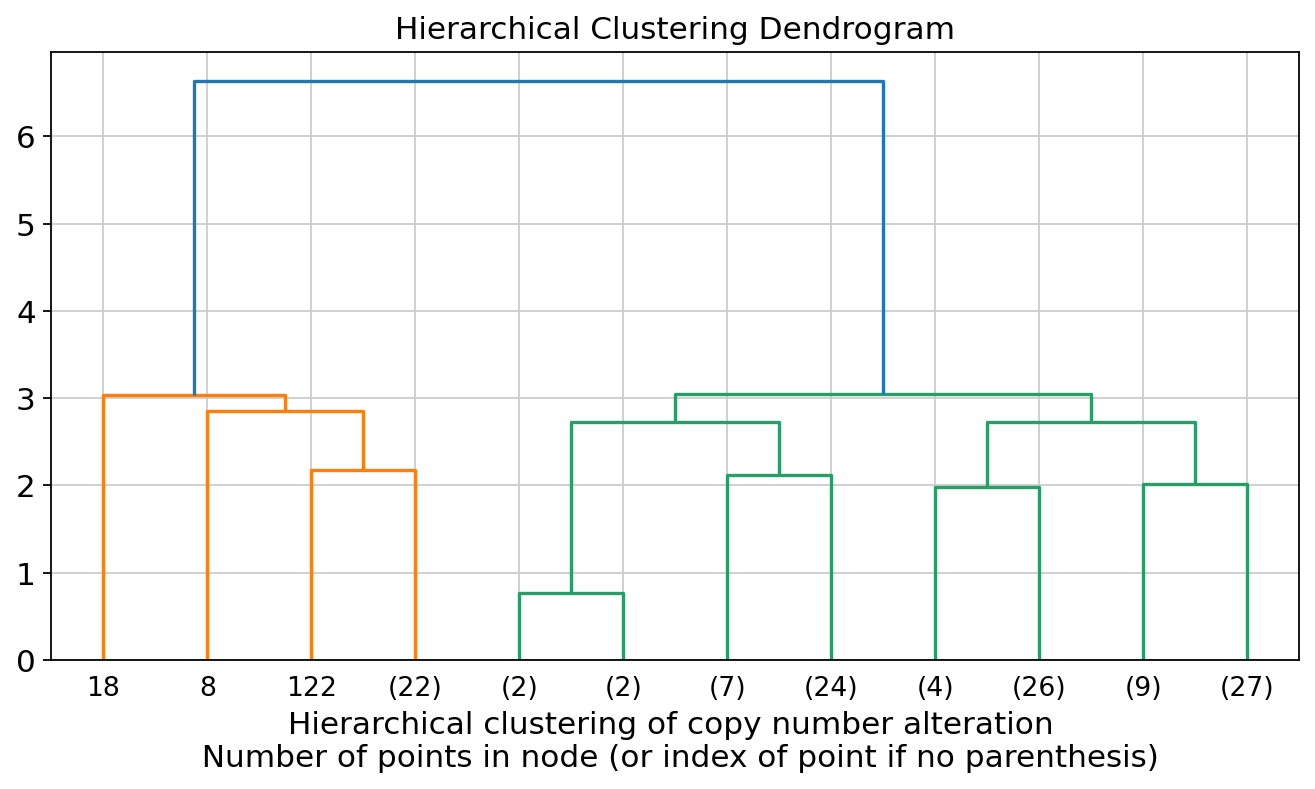

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

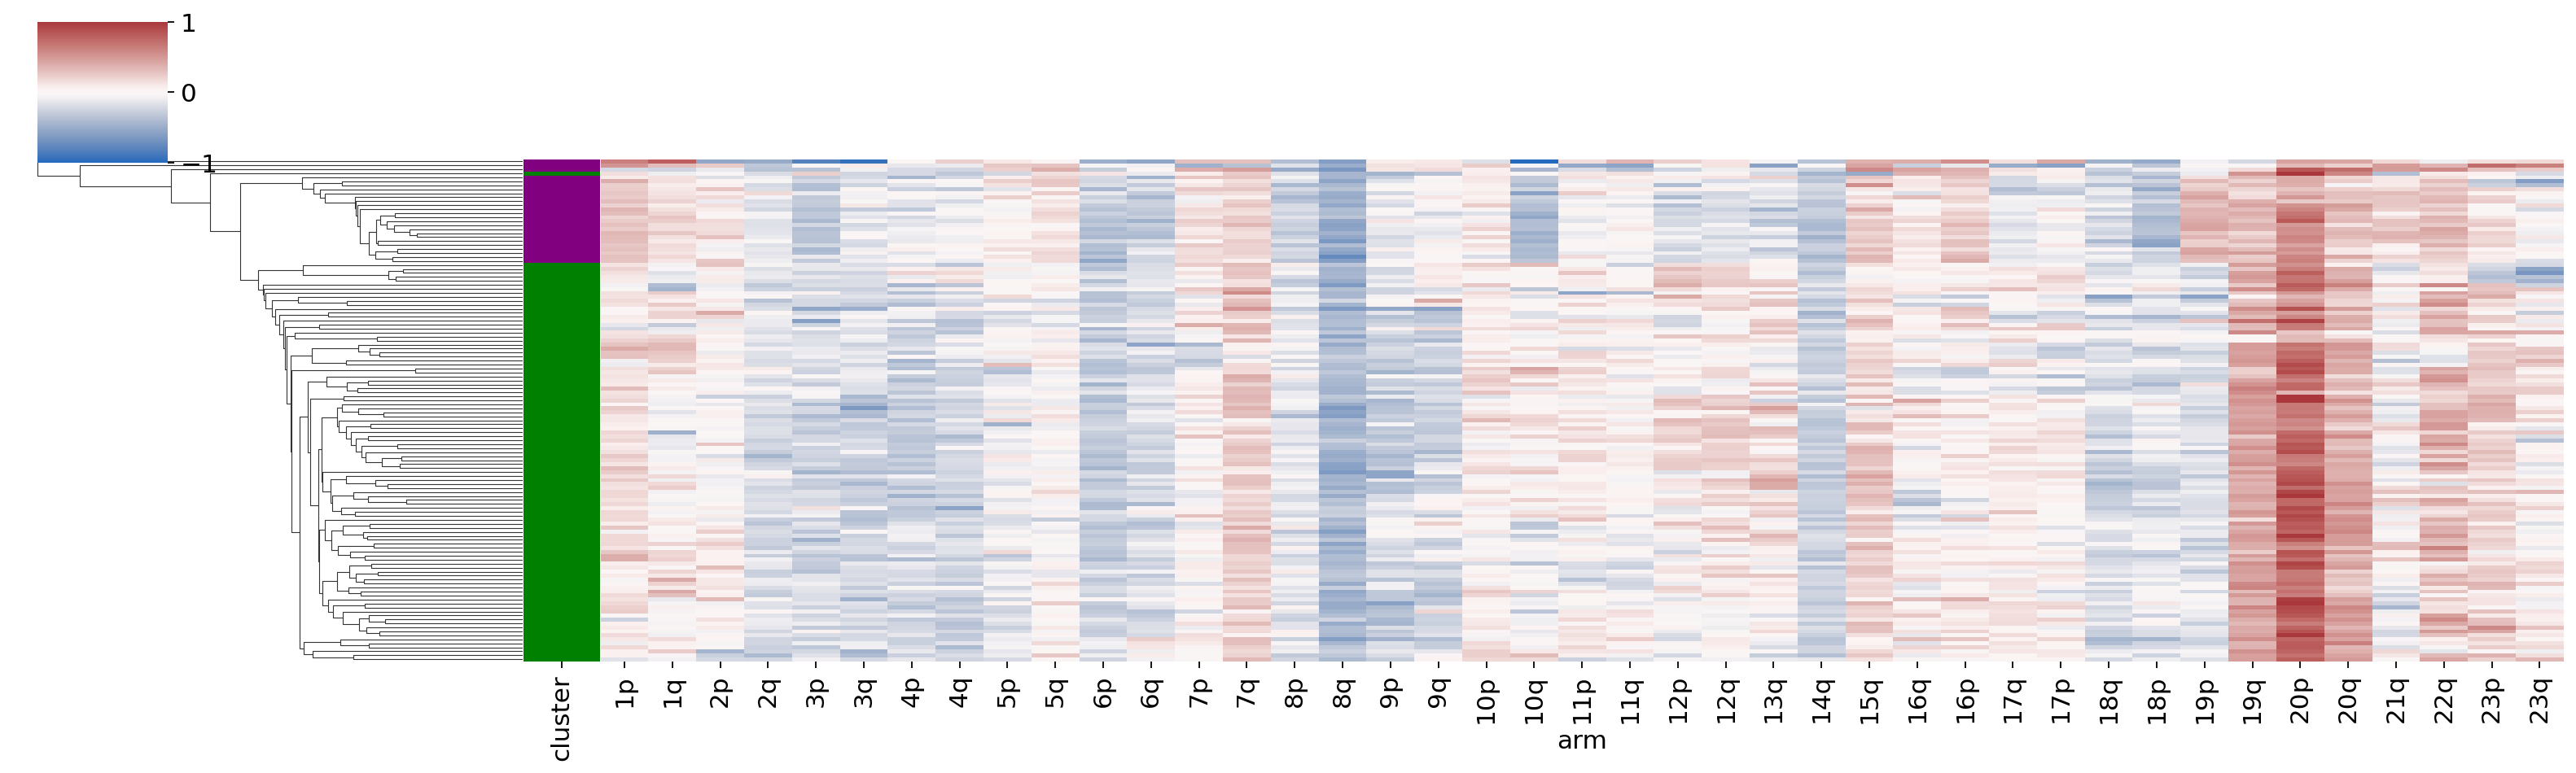

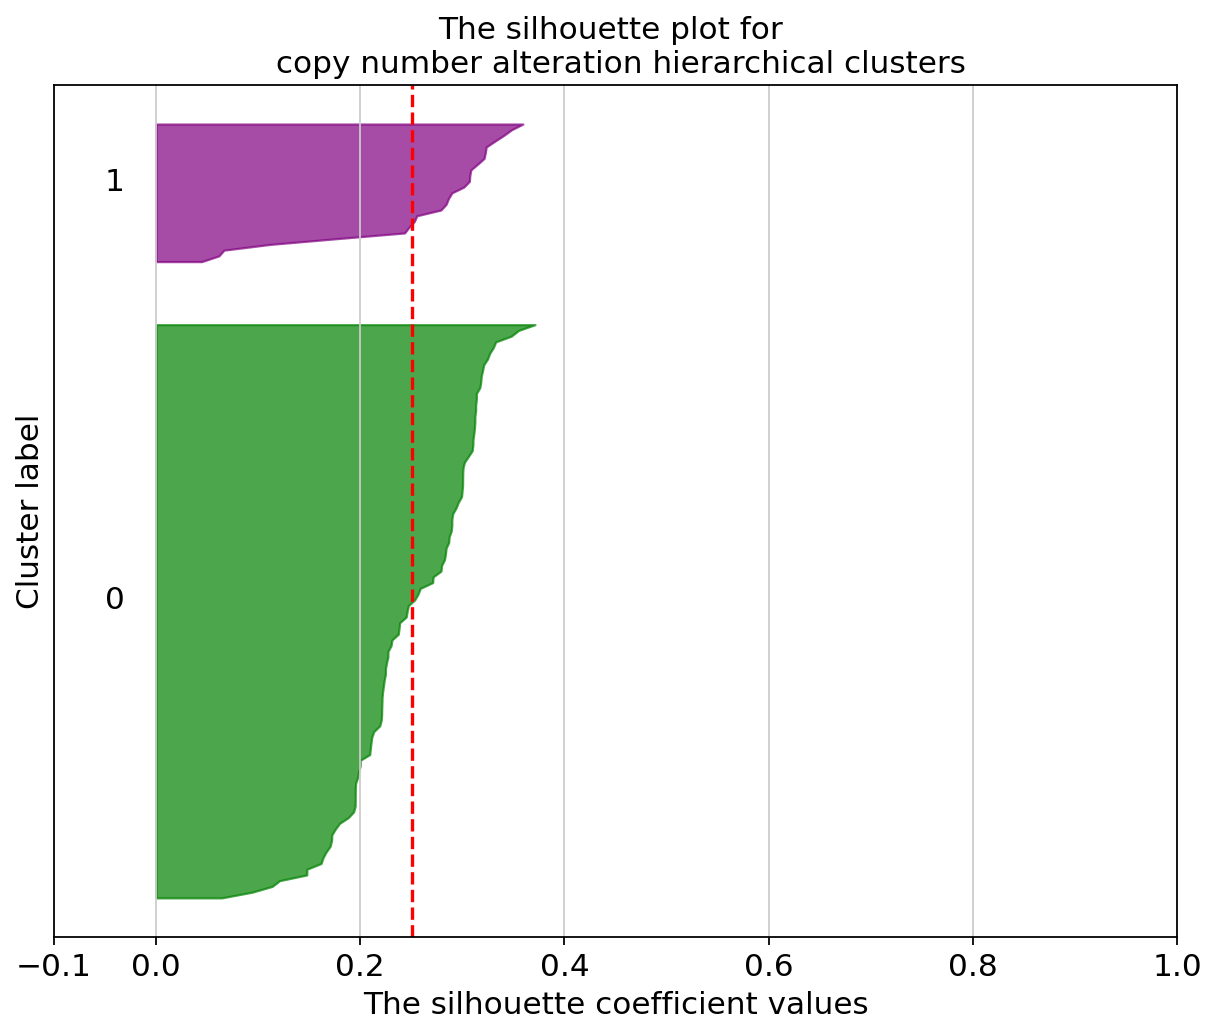

In [343]:
cluster_performance(p = 'OSRC2_KIDNEY' ) ##interesting

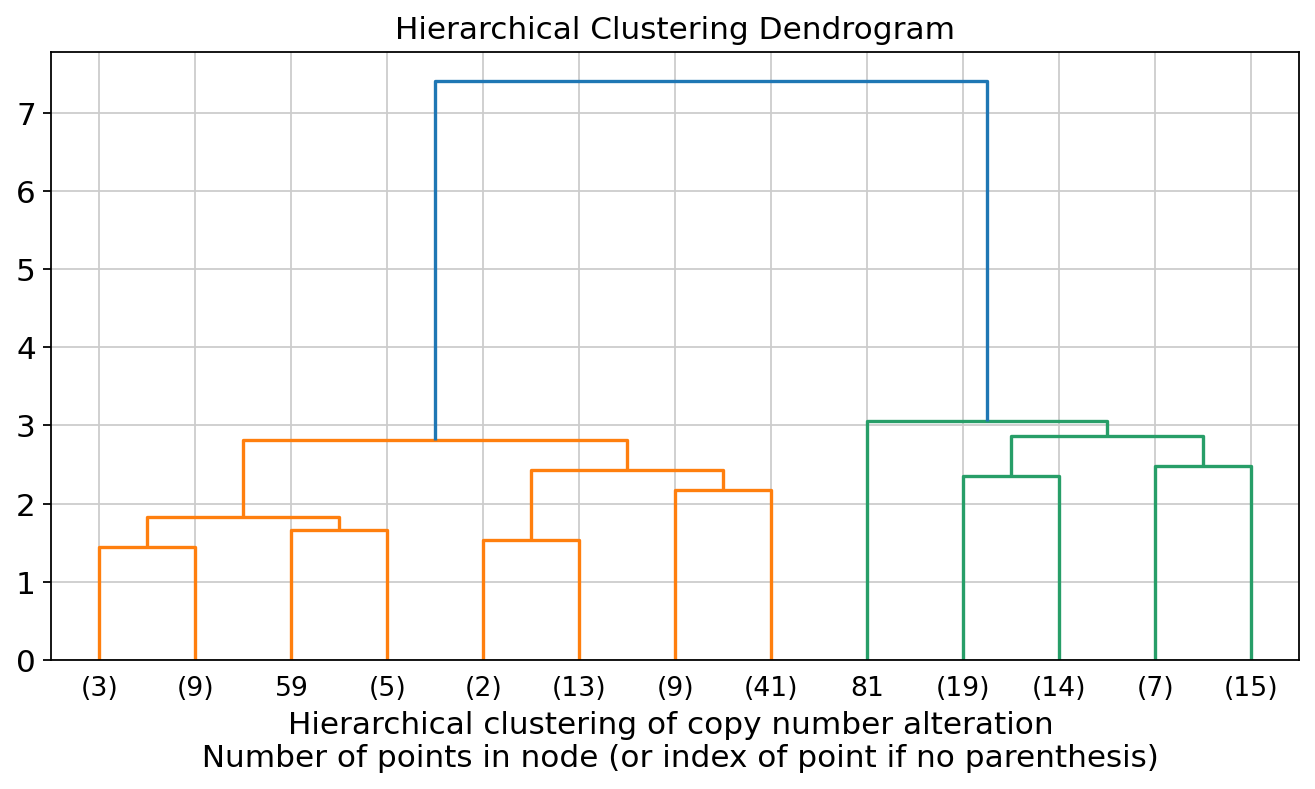

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

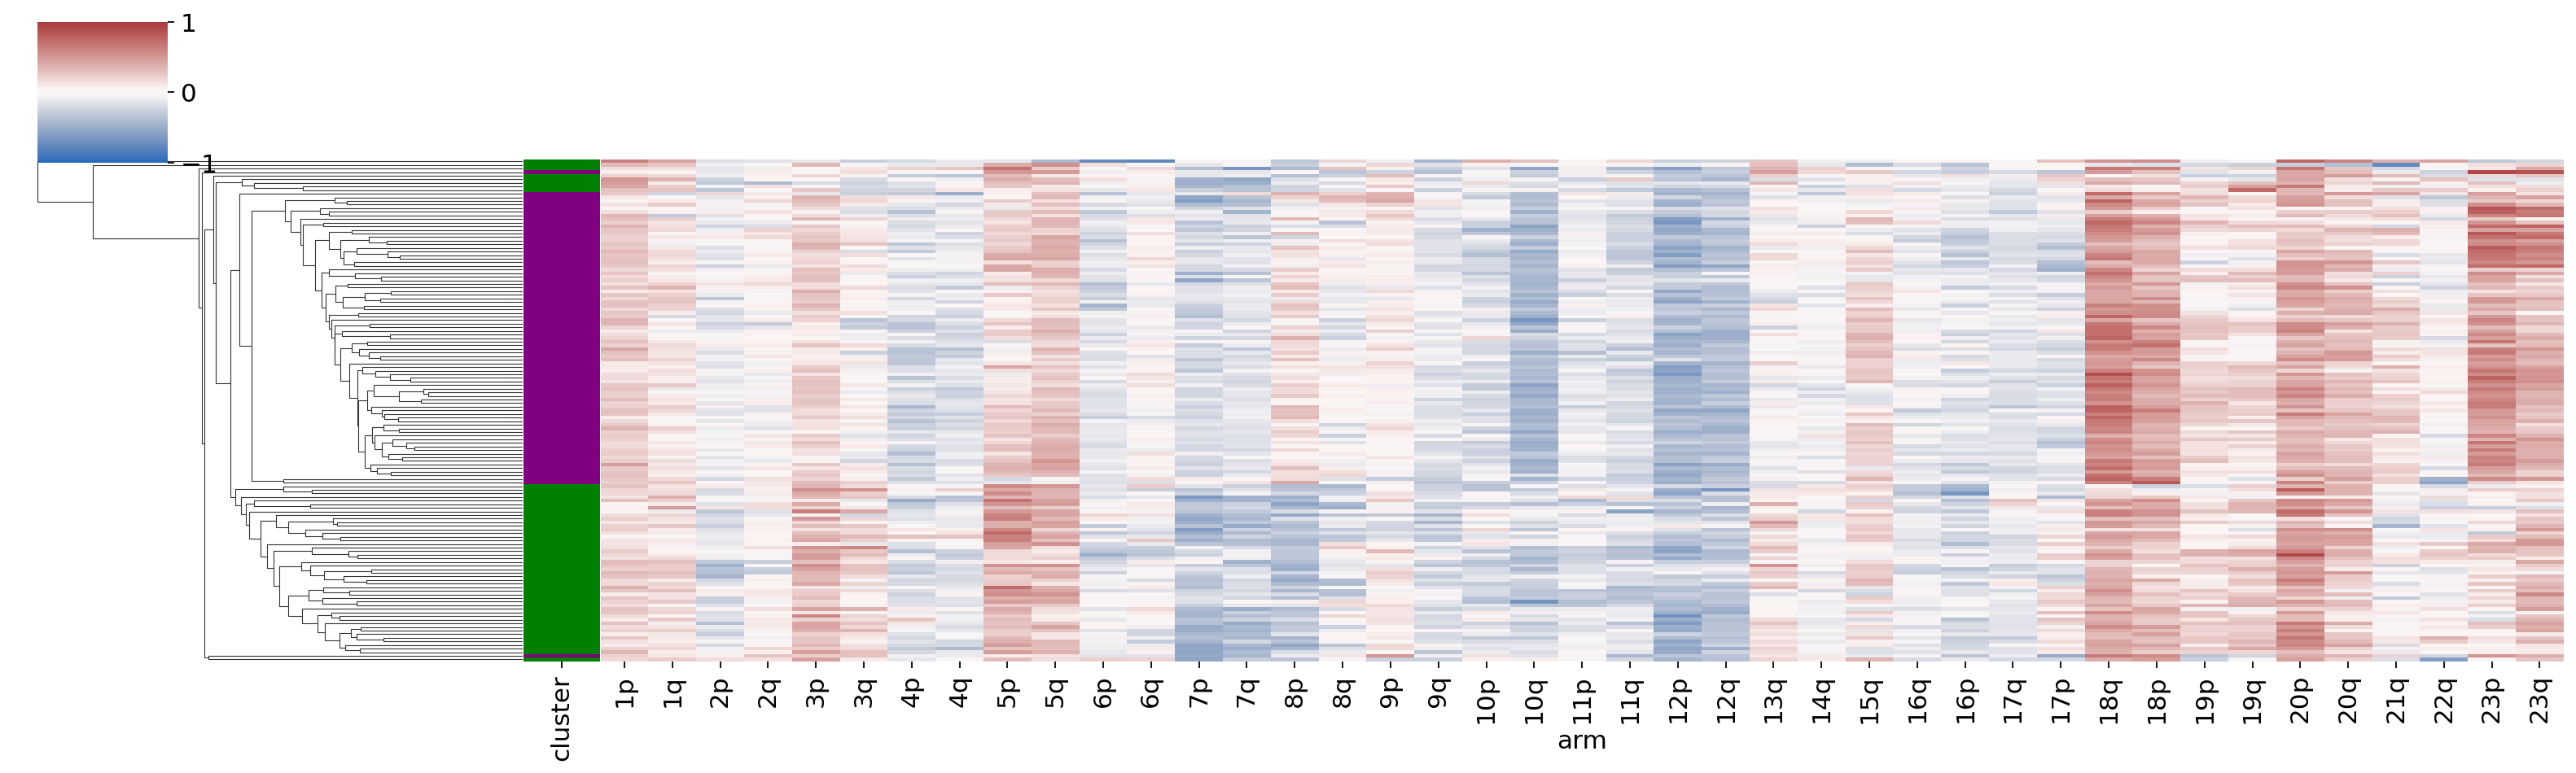

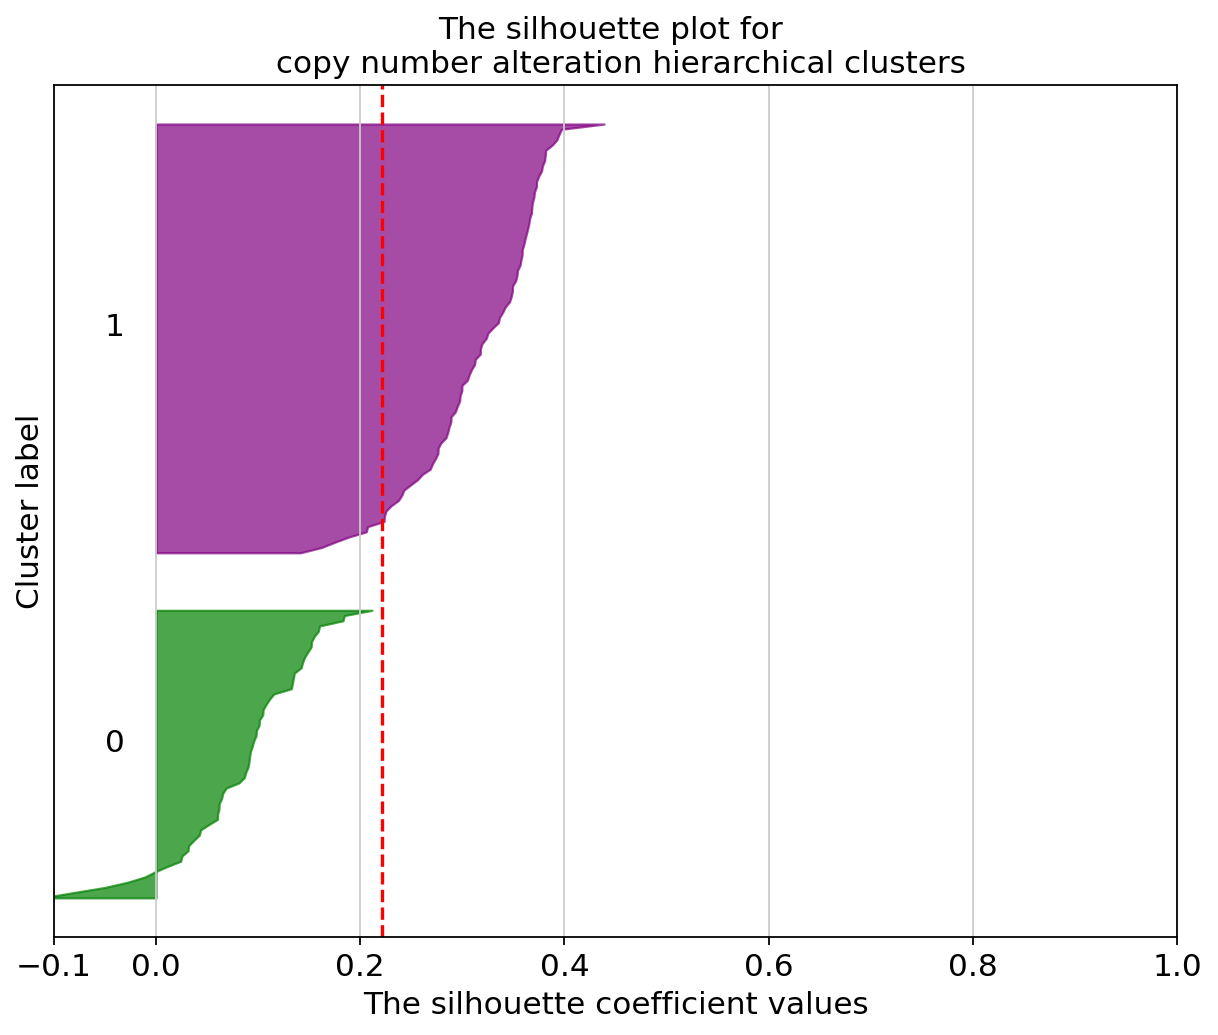

In [344]:
cluster_performance(p = 'HUH28_BILIARY_TRACT' ) 

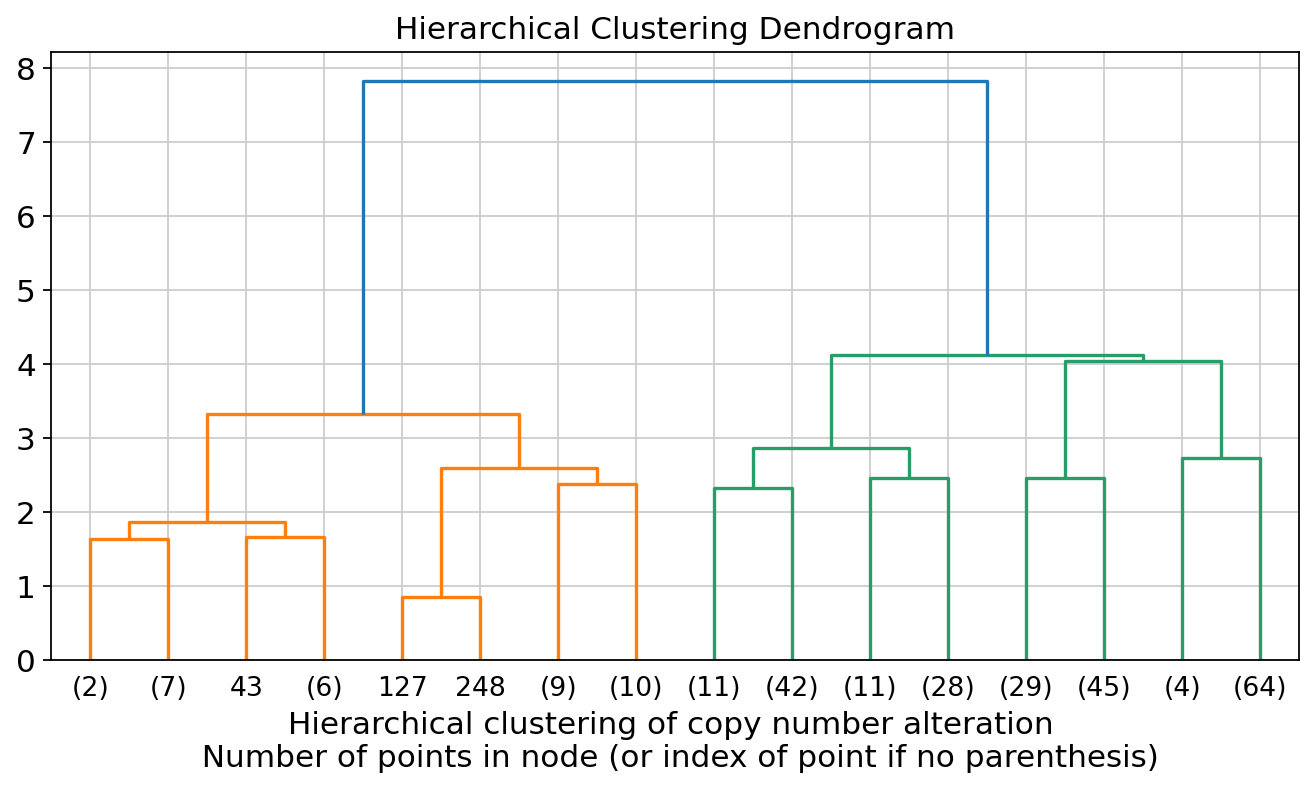

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


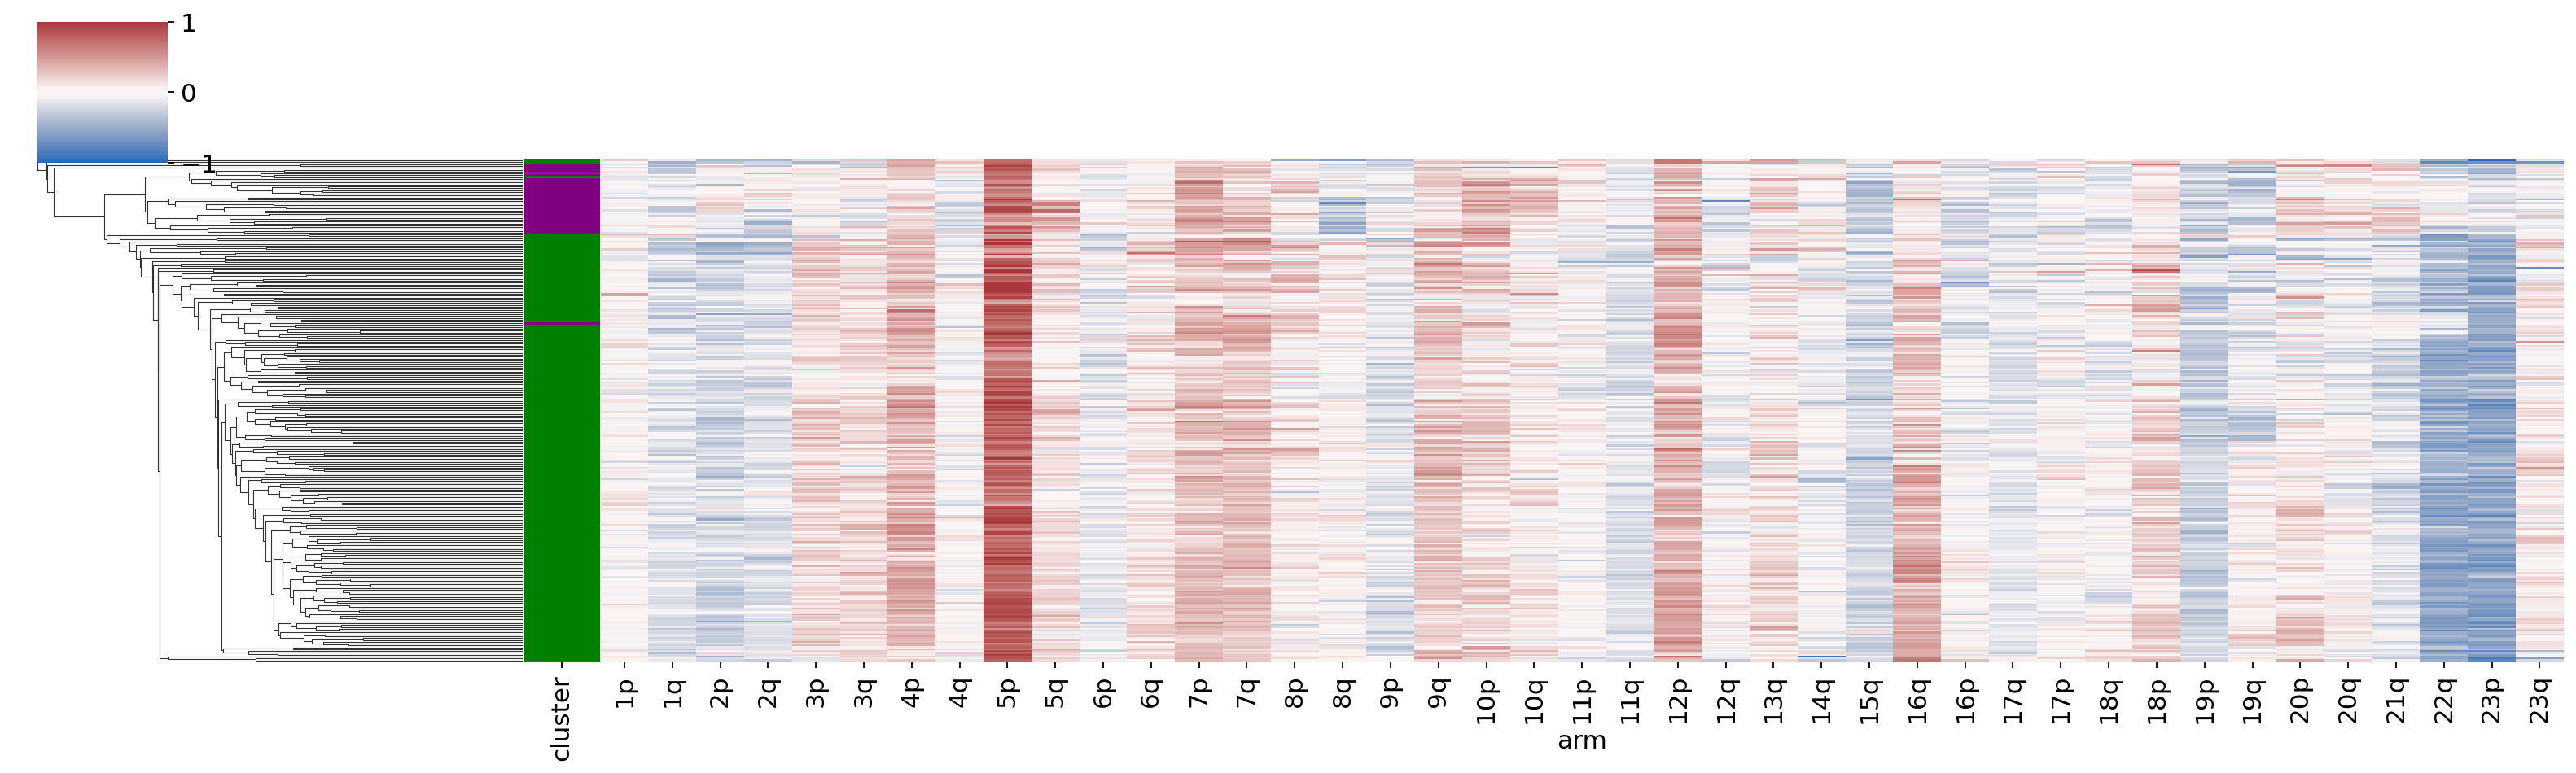

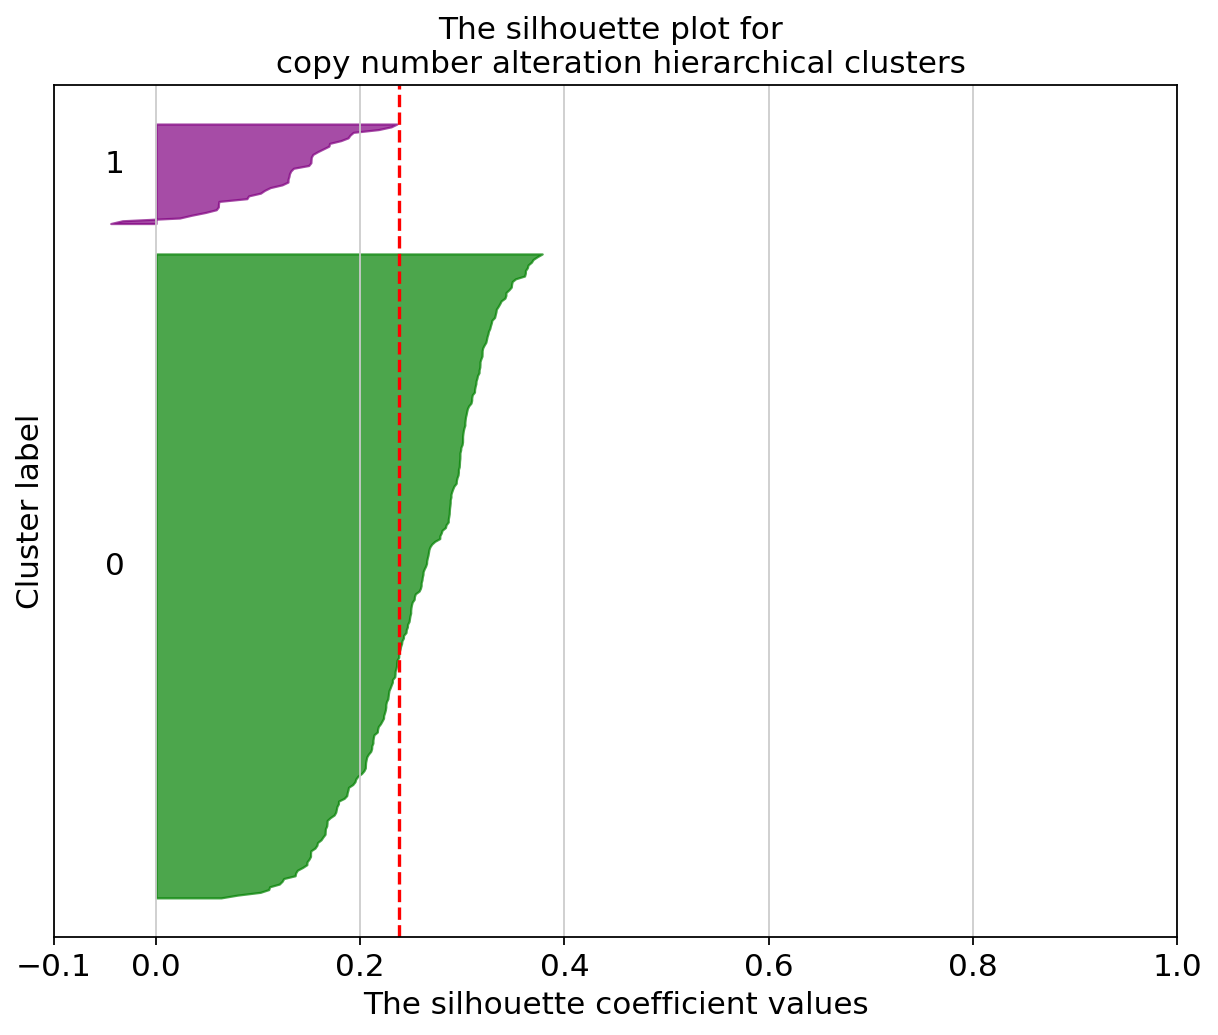

In [345]:
cluster_performance(p = 'PK45H_PANCREAS' ) ##interesting